<a href="https://colab.research.google.com/github/jhonaraujos/TCC_UNDB/blob/main/20_PASSAGENS_SHIFT_20_TESTE_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB

In [ ]:

import pandas as pd
from datetime import datetime

# Carregar os dados do CSV
df_original = pd.read_csv("/content/EVO - Degradaçao de Largura de Friso.csv", delimiter=';')

# Selecionar as colunas desejadas
colunas_desejadas = ["Train Time", "Vehicle Tag", "Vehicle Axle Number", "Side of Vehicle", "Site",  "Flange Thickness (mm)", "Flange Thickness Confidence",
"Flange Height (mm)", "Flange Height Confidence", "Rim Thickness (mm)", "Rim Thickness Confidence","Tread Hollow (mm)","Tread Hollow Confidence","Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]
df_original= df_original[colunas_desejadas]

# Remover duplicatas considerando todas as colunas
df_original = df_original.drop_duplicates()

# Filtrar o DataFrame para manter apenas as linhas onde "Flange Thickness (mm)" não é vazio e com medida com confiança e somente da Linha 1
df = df_original.loc[df_original["Site"] != "16K888 Lina 3"].copy()

# Criar a coluna "Date REF" com AM ou PM e remover AM/PM da coluna "Train Time"
df["Date REF"] = df["Train Time"].str.extract(r'(\bAM\b|\bPM\b)', expand=False)
df["Train Time"] = df["Train Time"].str.replace(r'\s*(AM|PM)\b', '', regex=True)

# Função para converter o formato de data/hora
def converter_train_time(data_hora, date_ref):
    try:
        if date_ref in ['AM', 'PM']:
            # Tentar converter datas no formato com AM/PM
            data_hora = datetime.strptime(data_hora, '%m/%d/%Y %I:%M:%S')
            if date_ref == 'PM' and data_hora.hour != 12:
                data_hora = data_hora.replace(hour=data_hora.hour + 12)
            elif date_ref == 'AM' and data_hora.hour == 12:
                data_hora = data_hora.replace(hour=0)
        else:
            # Tentar converter datas no formato padrão sem AM/PM
            try:
                data_hora = datetime.strptime(data_hora, '%m/%d/%Y %H:%M')
            except ValueError:
                data_hora = datetime.strptime(data_hora, '%m/%d/%Y %H:%M:%S')
        return data_hora  # Retorna como objeto datetime
    except ValueError:
        return None

# Converter o formato de "Train Time"
df["Train Time"] = df.apply(lambda row: converter_train_time(row["Train Time"], row["Date REF"]), axis=1)

# Garantir que 'Train Time' é datetime para ordenação correta
df['Train Time'] = pd.to_datetime(df['Train Time'], errors='coerce')  # Converte para datetime e trata erros

# Criar a coluna "id" com a junção das colunas Numero do veiculo + Numero do Rodeiro + Lado do Rodeiro (L = LEFT , R = RIGHT)
df["id"] = df["Vehicle Tag"] + "_" + df["Vehicle Axle Number"].astype(str) + "_" + df["Side of Vehicle"]

# Ordenar o DataFrame por "Train Time" em ordem crescente e depois por "Vehicle Axle Number"
df = df.sort_values(by=["Train Time", "Vehicle Axle Number"], ascending=[True, True])

# Criar a coluna "passagem" que conta sequencialmente cada valor único na coluna "id"
df["passagem"] = df.groupby('id').cumcount() + 1

# Ordenar novamente para exibir na ordem correta das passagens de forma crescente
df = df.sort_values(by=["id", "passagem"])
# Salvar o DataFrame filtrado em um novo arquivo CSV na pasta de saída

df

,Train Time,Vehicle Tag,Vehicle Axle Number,Side of Vehicle,Site,Flange Thickness (mm),Flange Thickness Confidence,Flange Height (mm),Flange Height Confidence,Rim Thickness (mm),Rim Thickness Confidence,Tread Hollow (mm),Tread Hollow Confidence,Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),Date REF,id,passagem
19452,2023-07-17 23:02:08,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.1,Yes,29.4,Yes,0.0,Yes,1.5,1515.7,1002.0,44.3,PM,EVO 2001_1_L,1
16716,2023-07-23 07:52:43,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.2,Yes,0.0,Yes,2.6,1516.1,1001.0,44.7,AM,EVO 2001_1_L,2
16260,2023-07-24 07:22:45,EVO 2001,1,L,16K888 Lina 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AM,EVO 2001_1_L,3
15456,2023-07-27 12:50:55,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.7,Yes,0.0,Yes,1.5,1515.3,1001.0,45.2,PM,EVO 2001_1_L,4
13920,2023-07-31 01:47:02,EVO 2001,1,L,16K888 Lina 1,25.3,Yes,30.4,Yes,29.4,Yes,0.0,Yes,1.4,1516.8,1000.0,42.2,AM,EVO 2001_1_L,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25911,2024-04-20 06:12:06,EVO 298,6,R,16K888 Lina 1,30.9,Yes,29.0,Yes,64.0,Yes,0.9,Yes,1.9,1516.3,1073.0,44.7,AM,EVO 298_6_R,79
78243,2024-05-01 12:39:00,EVO 298,6,R,16K888 Lina 1,31.4,Yes,29.4,Yes,63.6,Yes,0.5,Yes,2.0,1517.9,1070.0,42.9,NaN,EVO 298_6_R,80
22491,2024-05-15 06:42:37,EVO 298,6,R,16K888 Lina 1,27.1,Yes,29.1,Yes,63.4,Yes,0.4,No,5.4,1518.2,1071.0,43.3,AM,EVO 298_6_R,81
21639,2024-05-19 06:22:07,EVO 298,6,R,16K888 Lina 1,31.2,Yes,29.7,Yes,63.3,Yes,0.3,Yes,1.7,1517.9,1066.0,43.0,AM,EVO 298_6_R,82


In [ ]:
#ANALISE EXPLORATÓRIA ANTES PARA ENTENDIMENTO DAS AÇÕES DE MINIMIZAR OS RUÍDOS E FALSOS POSITIVOS

# Contagem do número total de IDs únicos
total_unique_ids = df['id'].nunique()

# Contagem do número de IDs com menos de 60 ocorrências
id_counts = df['id'].value_counts()
id_less_than_60 = (id_counts < 60).sum()

# Obter os 10 IDs mais frequentes
top_10_most = id_counts.head(10)

# Contar valores em branco na coluna 'Flange Thickness (mm)'
flange_thickness_na = df['Flange Thickness (mm)'].isna().sum()

# Contar valores 'No' na coluna 'Flange Thickness Confidence'
flange_thickness_no = (df['Flange Thickness Confidence'] == 'No').sum()

# Contar valores '16K888 Lina 2' na coluna 'Site'
site_16k888_lina2 = (df['Site'] == '16K888 Lina 2').sum()

# Preparar o resultado como um dicionário
result = {
    "Total ids": total_unique_ids,
    "ids menor que 60 passagens": id_less_than_60,
    "Top 10 ids com mais linhas": top_10_most.to_dict(),
    "Valores em branco na coluna 'Flange Thickness (mm)'": flange_thickness_na,
    "Valores 'No' na coluna 'Flange Thickness Confidence'": flange_thickness_no,
    "Valores na coluna 'Site' == '16K888 Lina 2'": site_16k888_lina2
}

result


{'Total ids': 1164,
 'ids menor que 60 passagens': 48,
 'Top 10 ids com mais linhas': {'EVO 227_4_L': 113,
  'EVO 227_1_R': 113,
  'EVO 227_4_R': 113,
  'EVO 227_3_R': 113,
  'EVO 227_3_L': 113,
  'EVO 227_2_R': 113,
  'EVO 227_2_L': 113,
  'EVO 227_1_L': 113,
  'EVO 227_6_R': 112,
  'EVO 227_5_L': 112},
 "Valores em branco na coluna 'Flange Thickness (mm)'": 3631,
 "Valores 'No' na coluna 'Flange Thickness Confidence'": 1218,
 "Valores na coluna 'Site' == '16K888 Lina 2'": 2988}

In [ ]:
import pandas as pd

# Reordenar o dataframe por 'id' e 'passagem' em ordem crescente para facilitar o preenchimento
df_sorted = df.sort_values(by=['id', 'passagem'], ascending=[True, True])

# Lista de colunas para aplicar a lógica de preenchimento
columns_to_fill = ["Flange Thickness (mm)", "Flange Height (mm)", "Rim Thickness (mm)",
                   "Tread Hollow (mm)", "Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]

# Função para preencher os valores nulos com a média dos últimos 3 valores anteriores, incluindo os valores substituídos
def fill_na_with_mean(group):
    for column in columns_to_fill:
        filled_values = group[column].copy()
        for i in range(len(filled_values)):
            if pd.isna(filled_values.iloc[i]):
                # Pegar os últimos 3 valores anteriores
                previous_values = filled_values.iloc[max(0, i-3):i]
                if not previous_values.empty:
                    mean_value = previous_values.mean()
                else:
                    # Se não houver valores anteriores, usar o próximo valor não nulo
                    mean_value = filled_values.iloc[i+1:].dropna().iloc[0]
                filled_values.iloc[i] = mean_value
        group[column] = filled_values
    return group

# Aplicar a função para cada grupo de 'id'
df_filled = df_sorted.groupby('id', group_keys=False).apply(fill_na_with_mean)

# Função para arredondar para baixo para uma casa decimal
def round_down_one_decimal(value):
    return (value * 10 // 1) / 10

# Aplicar a função de arredondamento para as colunas selecionadas
for column in columns_to_fill:
    df_filled[column] = df_filled[column].apply(round_down_one_decimal)

# Verificação para um ID específico
specific_id = 'EVO 2001_1_L'
original_na_specific = df[(df['id'] == specific_id) & (df[columns_to_fill].isna().any(axis=1))]
filled_na_specific_corrected = df_filled[(df_filled['id'] == specific_id) & (df_filled.index.isin(original_na_specific.index))]

original_na_specific_output = original_na_specific[['id', 'passagem'] + columns_to_fill]
filled_na_specific_corrected_output = filled_na_specific_corrected[['id', 'passagem'] + columns_to_fill]

display(original_na_specific_output, filled_na_specific_corrected_output)


,id,passagem,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13680,EVO 2001_1_L,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5088,EVO 2001_1_L,22,23.8,31.1,27.9,0.3,0.8,1517.0,NaN,41.7
57228,EVO 2001_1_L,26,32.3,28.4,NaN,0.0,1.5,1519.1,NaN,42.3
90062,EVO 2001_1_L,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38868,EVO 2001_1_L,55,29.3,27.5,35.8,0.0,2.0,1517.4,NaN,49.0
37704,EVO 2001_1_L,57,29.3,27.3,35.3,0.0,1.2,1518.2,NaN,49.9
76756,EVO 2001_1_L,59,29.4,27.3,35.3,0.0,0.5,1517.0,NaN,50.5
71536,EVO 2001_1_L,60,28.9,27.4,35.0,0.0,1.1,1517.7,NaN,50.7
66132,EVO 2001_1_L,61,28.6,27.3,NaN,0.0,2.0,1516.4,NaN,51.3


,id,passagem,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5
13680,EVO 2001_1_L,6,25.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9
5088,EVO 2001_1_L,22,23.8,31.1,27.9,0.3,0.8,1517.0,995.3,41.7
57228,EVO 2001_1_L,26,32.3,28.4,27.6,0.0,1.5,1519.1,995.0,42.3
90062,EVO 2001_1_L,36,31.1,28.6,35.7,0.0,2.2,1516.2,1010.6,45.8
38868,EVO 2001_1_L,55,29.3,27.5,35.8,0.0,2.0,1517.4,1010.3,49.0
37704,EVO 2001_1_L,57,29.3,27.3,35.3,0.0,1.2,1518.2,1010.4,49.9
76756,EVO 2001_1_L,59,29.4,27.3,35.3,0.0,0.5,1517.0,1009.1,50.5
71536,EVO 2001_1_L,60,28.9,27.4,35.0,0.0,1.1,1517.7,1008.8,50.7
66132,EVO 2001_1_L,61,28.6,27.3,35.1,0.0,2.0,1516.4,1008.3,51.3


In [ ]:


# Lista de colunas para aplicar a lógica de preenchimento
columns_to_fill = ["Flange Thickness (mm)", "Flange Height (mm)", "Rim Thickness (mm)",
                   "Tread Hollow (mm)", "Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]

# Função para preencher os valores com a média dos últimos 3 valores anteriores, incluindo os valores substituídos, quando o 'Site' for '16K888 Lina 2'
def fill_with_mean_for_specific_site(group):
    for column in columns_to_fill:
        filled_values = group[column].copy()
        for i in range(len(filled_values)):
            if group.iloc[i]['Site'] == '16K888 Lina 2':
                # Pegar os últimos 3 valores anteriores
                previous_values = filled_values.iloc[max(0, i-3):i]
                if not previous_values.empty:
                    mean_value = previous_values.mean()
                else:
                    # Se não houver valores anteriores, usar o próximo valor não nulo
                    mean_value = filled_values.iloc[i+1:].dropna().iloc[0]
                filled_values.iloc[i] = mean_value
        group[column] = filled_values
    return group

# Aplicar a função para cada grupo de 'id' na base já tratada pelo primeiro código
df_filled_site_specific = df_filled.groupby('id', group_keys=False).apply(fill_with_mean_for_specific_site)

# Função para arredondar para baixo para uma casa decimal
def round_down_one_decimal(value):
    return (value * 10 // 1) / 10

# Aplicar a função de arredondamento para as colunas selecionadas
for column in columns_to_fill:
    df_filled_site_specific[column] = df_filled_site_specific[column].apply(round_down_one_decimal)

# Verificação para um ID específico
specific_id = 'EVO 2001_1_L'
original_na_specific_site = df_filled[(df_filled['id'] == specific_id) & (df_filled['Site'] == '16K888 Lina 2')]
filled_na_specific_corrected_site = df_filled_site_specific[(df_filled_site_specific['id'] == specific_id) & (df_filled_site_specific['Site'] == '16K888 Lina 2') & (df_filled_site_specific.index.isin(original_na_specific_site.index))]

original_na_specific_site_output = original_na_specific_site[['id', 'passagem', 'Site'] + columns_to_fill]
filled_na_specific_corrected_site_output = filled_na_specific_corrected_site[['id', 'passagem', 'Site'] + columns_to_fill]

display(original_na_specific_site_output, filled_na_specific_corrected_site_output)



,id,passagem,Site,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,16K888 Lina 2,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5
13680,EVO 2001_1_L,6,16K888 Lina 2,25.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9
90062,EVO 2001_1_L,36,16K888 Lina 2,31.1,28.6,35.7,0.0,2.2,1516.2,1010.6,45.8


,id,passagem,Site,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,16K888 Lina 2,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5
13680,EVO 2001_1_L,6,16K888 Lina 2,25.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9
90062,EVO 2001_1_L,36,16K888 Lina 2,31.1,28.6,35.7,0.0,2.2,1516.2,1010.6,45.8


In [ ]:
import pandas as pd

# Lista de colunas para aplicar a lógica de preenchimento
columns_to_fill = ["Flange Thickness (mm)", "Flange Height (mm)", "Rim Thickness (mm)",
                   "Tread Hollow (mm)", "Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]

# Função para preencher os valores com a média dos últimos 3 valores anteriores, incluindo os valores substituídos, quando o 'Flange Thickness Confidence' for 'No'
def fill_with_mean_for_confidence_no(group):
    for column in columns_to_fill:
        filled_values = group[column].copy()
        for i in range(len(filled_values)):
            if group.iloc[i]['Flange Thickness Confidence'] == 'No':
                # Pegar os últimos 3 valores anteriores
                previous_values = filled_values.iloc[max(0, i-3):i]
                if not previous_values.empty:
                    mean_value = previous_values.mean()
                else:
                    # Se não houver valores anteriores, usar o próximo valor não nulo
                    mean_value = filled_values.iloc[i+1:].dropna().iloc[0]
                filled_values.iloc[i] = mean_value
        group[column] = filled_values
    return group

# Aplicar a função para cada grupo de 'id' na base já tratada pelos dois códigos anteriores
df_filled_confidence_no = df_filled_site_specific.groupby('id', group_keys=False).apply(fill_with_mean_for_confidence_no)

# Função para arredondar para baixo para uma casa decimal
def round_down_one_decimal(value):
    return (value * 10 // 1) / 10

# Aplicar a função de arredondamento para as colunas selecionadas
for column in columns_to_fill:
    df_filled_confidence_no[column] = df_filled_confidence_no[column].apply(round_down_one_decimal)

# Verificação para um ID específico e 'Flange Thickness Confidence' igual a 'No'
specific_id = 'EVO 2001_3_L'
original_na_specific_confidence = df_filled_site_specific[(df_filled_site_specific['id'] == specific_id) & (df_filled_site_specific['Flange Thickness Confidence'] == 'No')]
filled_na_specific_corrected_confidence = df_filled_confidence_no[(df_filled_confidence_no['id'] == specific_id) & (df_filled_confidence_no['Flange Thickness Confidence'] == 'No') & (df_filled_confidence_no.index.isin(original_na_specific_confidence.index))]

original_na_specific_confidence_output = original_na_specific_confidence[['id', 'passagem', 'Flange Thickness Confidence'] + columns_to_fill]
filled_na_specific_corrected_confidence_output = filled_na_specific_corrected_confidence[['id', 'passagem', 'Flange Thickness Confidence'] + columns_to_fill]

display(original_na_specific_confidence_output, filled_na_specific_corrected_confidence_output)


,id,passagem,Flange Thickness Confidence,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
27544,EVO 2001_3_L,85,No,29.5,30.1,32.3,2.2,1.4,1518.9,1006.0,37.2


,id,passagem,Flange Thickness Confidence,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
27544,EVO 2001_3_L,85,No,31.0,28.9,31.5,2.3,2.0,1515.4,1004.3,37.6


In [ ]:
# Salvar o dataframe final para continuar os tratamentos
df_final = df_filled_confidence_no

# Mostrar as primeiras linhas do dataframe final para verificação
df_final.head()

,Train Time,Vehicle Tag,Vehicle Axle Number,Side of Vehicle,Site,Flange Thickness (mm),Flange Thickness Confidence,Flange Height (mm),Flange Height Confidence,Rim Thickness (mm),Rim Thickness Confidence,Tread Hollow (mm),Tread Hollow Confidence,Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),Date REF,id,passagem
19452,2023-07-17 23:02:08,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.1,Yes,29.4,Yes,0.0,Yes,1.5,1515.7,1002.0,44.3,PM,EVO 2001_1_L,1
16716,2023-07-23 07:52:43,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.2,Yes,0.0,Yes,2.6,1516.1,1001.0,44.7,AM,EVO 2001_1_L,2
16260,2023-07-24 07:22:45,EVO 2001,1,L,16K888 Lina 2,25.4,NaN,30.2,NaN,29.3,NaN,0.0,NaN,2.0,1515.9,1001.5,44.5,AM,EVO 2001_1_L,3
15456,2023-07-27 12:50:55,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.7,Yes,0.0,Yes,1.5,1515.3,1001.0,45.2,PM,EVO 2001_1_L,4
13920,2023-07-31 01:47:02,EVO 2001,1,L,16K888 Lina 1,25.3,Yes,30.4,Yes,29.4,Yes,0.0,Yes,1.4,1516.8,1000.0,42.2,AM,EVO 2001_1_L,5


In [ ]:

# Calcular a quantidade de IDs antes da filtragem
initial_ids_count = df_final['id'].nunique()

# Filtrar os IDs que têm menos de 60 linhas diretamente no df_final
df_final_filtered = df_final.groupby('id').filter(lambda x: len(x) >= 60)

# Calcular a quantidade de IDs depois da filtragem
filtered_ids_count = df_final_filtered['id'].nunique()

# Calcular a quantidade de IDs excluídos
excluded_ids_count = initial_ids_count - filtered_ids_count

# Mostrar a quantidade de IDs excluídos
print(f"Quantidade de IDs excluídos: {excluded_ids_count}")

# Mostrar a quantidade de IDs restantes
print(f"Quantidade de IDs restantes: {filtered_ids_count}")

# Atualizar df_final
df_final = df_final_filtered


Quantidade de IDs excluídos: 48
Quantidade de IDs restantes: 1116


In [ ]:
# Verificar valores em branco nas colunas 'passagem' e 'Flange Thickness (mm)'
blank_passagem = df_final['passagem'].isna().sum()
blank_flange_thickness = df_final['Flange Thickness (mm)'].isna().sum()

print(f"Valores em branco na coluna 'passagem': {blank_passagem}")
print(f"Valores em branco na coluna 'Flange Thickness (mm)': {blank_flange_thickness}")

Valores em branco na coluna 'passagem': 0
Valores em branco na coluna 'Flange Thickness (mm)': 0


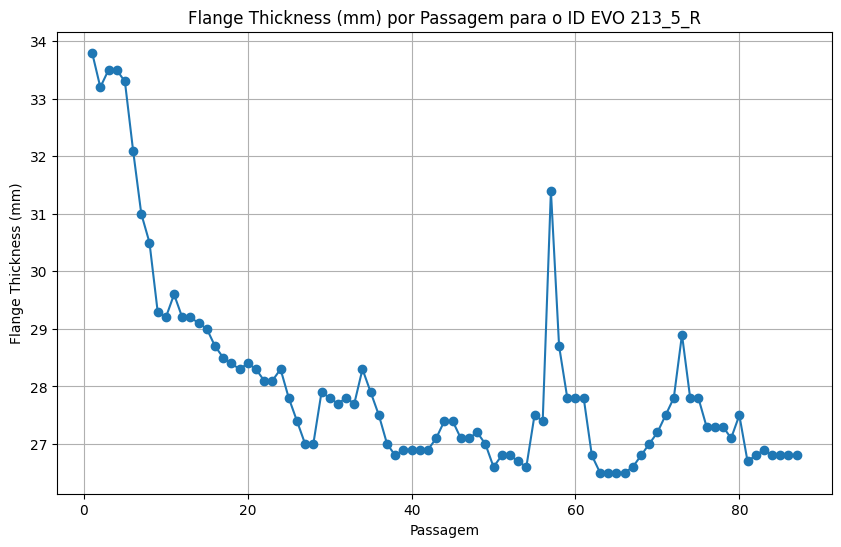

In [ ]:
import matplotlib.pyplot as plt

# Definir o ID específico que deseja plotar
specific_id = 'EVO 213_5_R'

# Filtrar o dataframe final para o ID específico
df_specific = df_final[df_final['id'] == specific_id]

# Plotar Flange Thickness (mm) por passagem
plt.figure(figsize=(10, 6))
plt.plot(df_specific['passagem'], df_specific['Flange Thickness (mm)'], marker='o', linestyle='-')
plt.title(f'Flange Thickness (mm) por Passagem para o ID {specific_id}')
plt.xlabel('Passagem')
plt.ylabel('Flange Thickness (mm)')
plt.grid(True)
plt.show()


                id  Regression Slope  Intercept
85    EVO 2010_1_R         -0.091530  32.371944
315    EVO 229_2_R         -0.078063  30.806957
961    EVO 286_1_R         -0.076290  31.616105
835    EVO 275_4_R         -0.075799  33.510940
721    EVO 266_1_R         -0.072701  34.054819
35    EVO 2003_6_R         -0.070487  34.206152
595    EVO 253_4_R         -0.068570  29.724542
155    EVO 215_6_R         -0.067640  34.300440
25    EVO 2003_1_R         -0.066962  32.205024
973    EVO 287_1_R         -0.065902  31.812460
553    EVO 250_1_R         -0.065898  29.878829
966    EVO 286_4_L         -0.062794  31.333368
89    EVO 2010_3_R         -0.062161  34.138871
792    EVO 272_1_L         -0.061805  30.823745
60    EVO 2008_1_L         -0.060312  30.284049
559    EVO 250_4_R         -0.058790  29.445389
793    EVO 272_1_R         -0.058468  30.046133
1003   EVO 289_4_R         -0.058090  31.079775
488    EVO 244_5_L         -0.056596  31.926242
121    EVO 213_1_R         -0.055963  29

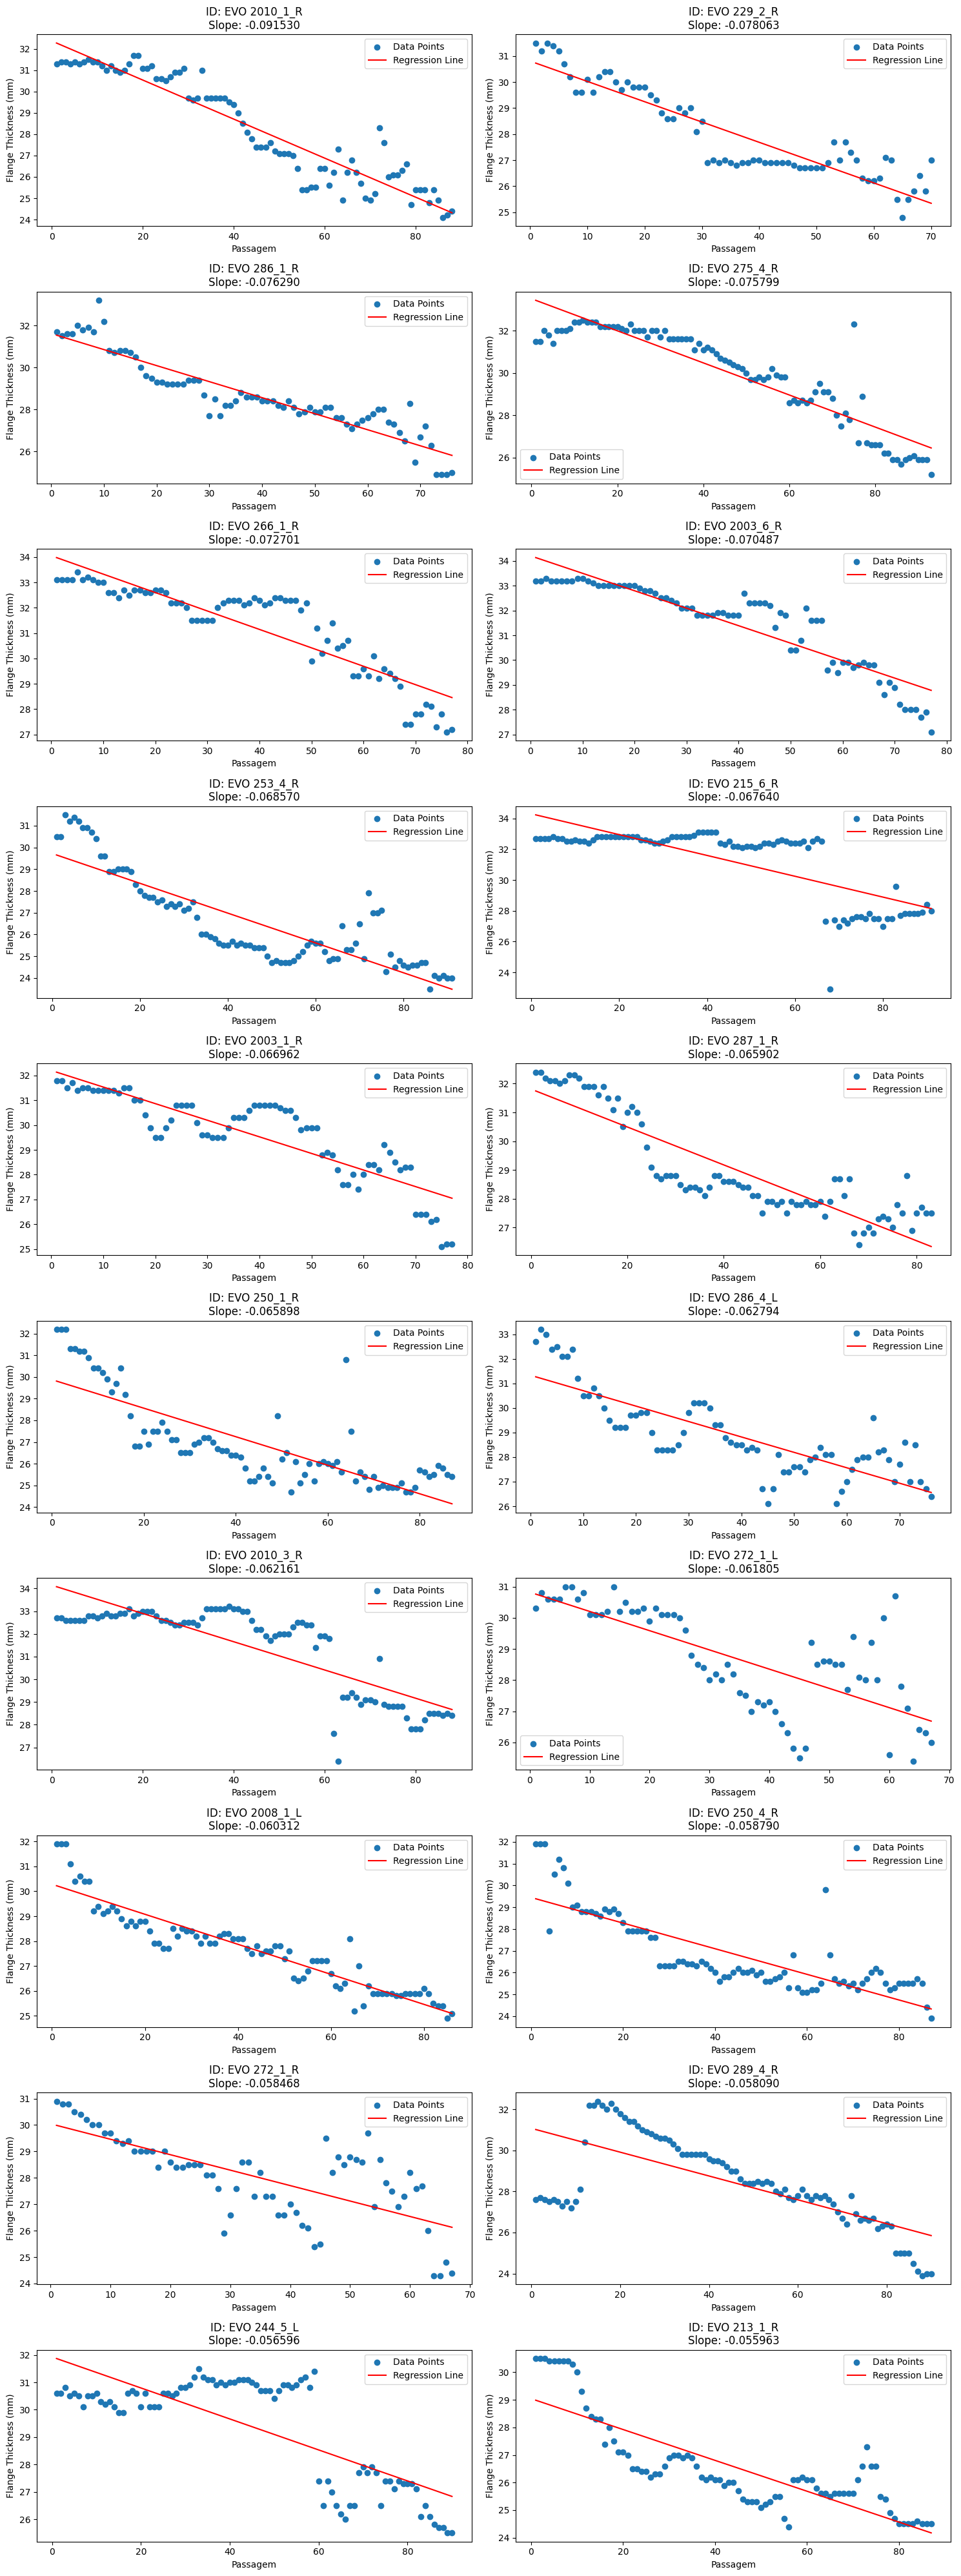

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt



# Função para ajustar uma linha de regressão e retornar a inclinação
def calculate_regression_slope(group):
    X = sm.add_constant(group['passagem'])
    y = group['Flange Thickness (mm)']
    model = sm.OLS(y, X).fit()
    slope = model.params['passagem']
    return pd.Series({
        'Regression Slope': slope,
        'Intercept': model.params['const']
    })

# Aplicar a função para cada grupo de 'id'
regression_slope_df = df_final.groupby('id').apply(calculate_regression_slope).reset_index()

# Ordenar os IDs pela maior inclinação (negativa) da regressão
regression_slope_df_sorted = regression_slope_df.sort_values(by='Regression Slope', ascending=True)

# Exibir os 20 IDs com a maior taxa de degradação (maior inclinação negativa)
top_20_regression_slope = regression_slope_df_sorted.head(20)
print(top_20_regression_slope)

# Plotar as linhas de regressão para os 20 IDs com a maior taxa de degradação
fig, axs = plt.subplots(10, 2, figsize=(15, 40))
axs = axs.flatten()

for ax, (i, row) in zip(axs, top_20_regression_slope.iterrows()):
    specific_id = row['id']
    intercept = row['Intercept']
    slope = row['Regression Slope']

    df_specific_id = df_final[df_final['id'] == specific_id]
    X = df_specific_id['passagem']
    y = df_specific_id['Flange Thickness (mm)']

    ax.scatter(X, y, label='Data Points')
    ax.plot(X, intercept + slope * X, color='red', label='Regression Line')
    ax.set_title(f"ID: {specific_id}\nSlope: {slope:.6f}")
    ax.set_xlabel('Passagem')
    ax.set_ylabel('Flange Thickness (mm)')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
#df_final = df_final[df_final['id'] == 'EVO 213_5_R']

# Mostrar as primeiras linhas do dataframe filtrado para verificação
#df_final_specific.head()


In [ ]:
df_final = df_final.drop(['Vehicle Tag','Vehicle Axle Number','Side of Vehicle','Site','Flange Height Confidence','Flange Thickness Confidence','Rim Thickness Confidence','Tread Hollow Confidence','Date REF'], axis=1)
df_final

,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem
19452,2023-07-17 23:02:08,25.4,30.1,29.4,0.0,1.5,1515.7,1002.0,44.3,EVO 2001_1_L,1
16716,2023-07-23 07:52:43,25.4,30.3,29.2,0.0,2.6,1516.1,1001.0,44.7,EVO 2001_1_L,2
16260,2023-07-24 07:22:45,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5,EVO 2001_1_L,3
15456,2023-07-27 12:50:55,25.4,30.3,29.7,0.0,1.5,1515.3,1001.0,45.2,EVO 2001_1_L,4
13920,2023-07-31 01:47:02,25.3,30.4,29.4,0.0,1.4,1516.8,1000.0,42.2,EVO 2001_1_L,5
...,...,...,...,...,...,...,...,...,...,...,...
25911,2024-04-20 06:12:06,30.9,29.0,64.0,0.9,1.9,1516.3,1073.0,44.7,EVO 298_6_R,79
78243,2024-05-01 12:39:00,31.4,29.4,63.6,0.5,2.0,1517.9,1070.0,42.9,EVO 298_6_R,80
22491,2024-05-15 06:42:37,27.1,29.1,63.4,0.4,5.4,1518.2,1071.0,43.3,EVO 298_6_R,81
21639,2024-05-19 06:22:07,31.2,29.7,63.3,0.3,1.7,1517.9,1066.0,43.0,EVO 298_6_R,82


In [ ]:
import numpy as np

# Função para aplicar as operações para cada grupo de ID
def apply_operations(group):
    group['MM5d'] = group['Flange Thickness (mm)'].rolling(window=5).mean().round(2)
    group['MM10d'] = group['Flange Thickness (mm)'].rolling(window=10).mean().round(2)
    group['MM30d'] = group['Flange Thickness (mm)'].rolling(window=30).mean().round(2)

    # Mudança percentual na espessura da flange em relação ao valor anterior
    group['Flange_Thickness_Change'] = group['Flange Thickness (mm)'].pct_change()

    # Substitui os valores infinitos (causados pela divisão por zero) por NaN
    group['Flange_Thickness_Change'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Preencher NaN com 0 na mudança percentual
    group['Flange_Thickness_Change'].fillna(0, inplace=True)

    # Função para preencher valores em branco nas médias móveis com a média dos valores anteriores
    def fill_na_with_previous_mean(series):
        for i in range(len(series)):
            if pd.isna(series.iloc[i]):
                if i == 0:
                    series.iloc[i] = group['Flange Thickness (mm)'].iloc[i]
                else:
                    series.iloc[i] = group['Flange Thickness (mm)'].iloc[:i].mean()
        return series

    group['MM5d'] = fill_na_with_previous_mean(group['MM5d'])
    group['MM10d'] = fill_na_with_previous_mean(group['MM10d'])
    group['MM30d'] = fill_na_with_previous_mean(group['MM30d'])

    return group

# Aplicar a função para cada grupo de 'id'
df_final = df_final.groupby('id', group_keys=False).apply(apply_operations)

# Mostrar as primeiras linhas do dataframe final para verificação
df_final.head(31)


,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change
19452,2023-07-17 23:02:08,25.4,30.1,29.4,0.0,1.5,1515.7,1002.0,44.3,EVO 2001_1_L,1,25.40,25.400000,25.400000,0.000000
16716,2023-07-23 07:52:43,25.4,30.3,29.2,0.0,2.6,1516.1,1001.0,44.7,EVO 2001_1_L,2,25.40,25.400000,25.400000,0.000000
16260,2023-07-24 07:22:45,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5,EVO 2001_1_L,3,25.40,25.400000,25.400000,0.000000
15456,2023-07-27 12:50:55,25.4,30.3,29.7,0.0,1.5,1515.3,1001.0,45.2,EVO 2001_1_L,4,25.40,25.400000,25.400000,0.000000
13920,2023-07-31 01:47:02,25.3,30.4,29.4,0.0,1.4,1516.8,1000.0,42.2,EVO 2001_1_L,5,25.38,25.400000,25.400000,-0.003937
13680,2023-07-31 16:55:44,25.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9,EVO 2001_1_L,6,25.36,25.380000,25.380000,0.000000
94624,2023-08-04 05:06:00,25.2,30.5,29.1,0.0,1.9,1516.9,997.0,42.8,EVO 2001_1_L,7,25.32,25.366667,25.366667,-0.003953
87052,2023-08-08 12:35:00,23.1,30.3,29.1,0.0,0.2,1515.4,1002.0,44.3,EVO 2001_1_L,8,24.86,25.342857,25.342857,-0.083333
82504,2023-08-11 19:37:00,24.0,30.2,29.4,0.0,1.3,1516.6,1002.0,44.2,EVO 2001_1_L,9,24.58,25.062500,25.062500,0.038961
12468,2023-08-15 16:02:23,24.0,30.4,29.1,0.0,3.9,1515.5,1000.0,43.8,EVO 2001_1_L,10,24.32,24.850000,24.944444,0.000000


In [ ]:
# Primeiro, agrupe os dados por 'id'
groups = df_final.groupby('id')

# Defina uma função para calcular a degradação por passagem
def calculate_degradation(row, first_value):
    return (row['Flange Thickness (mm)'] - first_value) / row['passagem']

# Aplique essa função a cada grupo
for name, group in groups:
    first_value = group.iloc[0]['Flange Thickness (mm)']
    df_final.loc[group.index, 'Degradation per Passage'] = group.apply(calculate_degradation, axis=1, first_value=first_value)

# Exibir o DataFrame resultante para verificação
display(df_final)


,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19452,2023-07-17 23:02:08,25.4,30.1,29.4,0.0,1.5,1515.7,1002.0,44.3,EVO 2001_1_L,1,25.40,25.40,25.40,0.000000,0.000000
16716,2023-07-23 07:52:43,25.4,30.3,29.2,0.0,2.6,1516.1,1001.0,44.7,EVO 2001_1_L,2,25.40,25.40,25.40,0.000000,0.000000
16260,2023-07-24 07:22:45,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5,EVO 2001_1_L,3,25.40,25.40,25.40,0.000000,0.000000
15456,2023-07-27 12:50:55,25.4,30.3,29.7,0.0,1.5,1515.3,1001.0,45.2,EVO 2001_1_L,4,25.40,25.40,25.40,0.000000,0.000000
13920,2023-07-31 01:47:02,25.3,30.4,29.4,0.0,1.4,1516.8,1000.0,42.2,EVO 2001_1_L,5,25.38,25.40,25.40,-0.003937,-0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25911,2024-04-20 06:12:06,30.9,29.0,64.0,0.9,1.9,1516.3,1073.0,44.7,EVO 298_6_R,79,32.06,32.74,32.73,-0.015924,-0.017722
78243,2024-05-01 12:39:00,31.4,29.4,63.6,0.5,2.0,1517.9,1070.0,42.9,EVO 298_6_R,80,31.62,32.48,32.68,0.016181,-0.011250
22491,2024-05-15 06:42:37,27.1,29.1,63.4,0.4,5.4,1518.2,1071.0,43.3,EVO 298_6_R,81,30.34,31.91,32.49,-0.136943,-0.064198
21639,2024-05-19 06:22:07,31.2,29.7,63.3,0.3,1.7,1517.9,1066.0,43.0,EVO 298_6_R,82,30.40,31.70,32.43,0.151292,-0.013415


In [ ]:
# Função para selecionar as últimas 20 passagens de cada grupo de ID
def select_last_n_passages(group, n=20):
    return group.tail(n)

# Aplicar a função a cada grupo de ID
df_prever = df_final.groupby('id', group_keys=False).apply(select_last_n_passages, n=20)

# Remover as últimas 20 passagens de cada grupo do dataframe original
df_final = df_final.groupby('id', group_keys=False).apply(lambda x: x.iloc[:-20] if len(x) > 20 else x)

# Mostrar os dataframes resultantes para verificação
display(df_prever)
display(df_final)




,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
34224,2024-02-27 10:55:36,28.3,28.7,31.5,0.0,2.3,1514.3,1003.0,53.3,EVO 2001_1_L,75,28.54,28.58,28.85,0.029091,0.038667
78902,2024-03-01 09:17:00,27.9,28.7,32.7,0.0,0.6,1516.7,1005.7,50.0,EVO 2001_1_L,76,28.28,28.47,28.82,-0.014134,0.032895
78662,2024-03-01 23:59:00,28.3,28.7,32.0,0.0,2.9,1514.9,1004.0,51.9,EVO 2001_1_L,77,28.06,28.42,28.78,0.014337,0.037662
74882,2024-03-04 12:02:00,28.9,28.7,32.0,0.0,2.2,1516.8,1004.2,49.3,EVO 2001_1_L,78,28.18,28.43,28.77,0.021201,0.044872
73562,2024-03-05 14:07:00,28.4,28.7,32.0,0.0,2.0,1514.1,1004.0,50.7,EVO 2001_1_L,79,28.36,28.30,28.76,-0.017301,0.037975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25911,2024-04-20 06:12:06,30.9,29.0,64.0,0.9,1.9,1516.3,1073.0,44.7,EVO 298_6_R,79,32.06,32.74,32.73,-0.015924,-0.017722
78243,2024-05-01 12:39:00,31.4,29.4,63.6,0.5,2.0,1517.9,1070.0,42.9,EVO 298_6_R,80,31.62,32.48,32.68,0.016181,-0.011250
22491,2024-05-15 06:42:37,27.1,29.1,63.4,0.4,5.4,1518.2,1071.0,43.3,EVO 298_6_R,81,30.34,31.91,32.49,-0.136943,-0.064198
21639,2024-05-19 06:22:07,31.2,29.7,63.3,0.3,1.7,1517.9,1066.0,43.0,EVO 298_6_R,82,30.40,31.70,32.43,0.151292,-0.013415


,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19452,2023-07-17 23:02:08,25.4,30.1,29.4,0.0,1.5,1515.7,1002.0,44.3,EVO 2001_1_L,1,25.40,25.40,25.40,0.000000,0.000000
16716,2023-07-23 07:52:43,25.4,30.3,29.2,0.0,2.6,1516.1,1001.0,44.7,EVO 2001_1_L,2,25.40,25.40,25.40,0.000000,0.000000
16260,2023-07-24 07:22:45,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5,EVO 2001_1_L,3,25.40,25.40,25.40,0.000000,0.000000
15456,2023-07-27 12:50:55,25.4,30.3,29.7,0.0,1.5,1515.3,1001.0,45.2,EVO 2001_1_L,4,25.40,25.40,25.40,0.000000,0.000000
13920,2023-07-31 01:47:02,25.3,30.4,29.4,0.0,1.4,1516.8,1000.0,42.2,EVO 2001_1_L,5,25.38,25.40,25.40,-0.003937,-0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61931,2024-01-19 20:55:07,32.4,27.5,41.3,0.0,2.2,1513.7,1025.0,45.2,EVO 298_6_R,59,32.56,32.64,32.91,0.000000,0.001695
60971,2024-01-22 17:12:04,32.5,27.0,41.3,0.0,2.2,1515.2,1027.0,43.8,EVO 298_6_R,60,32.54,32.59,32.89,0.003086,0.003333
60515,2024-01-24 00:34:05,32.4,27.2,41.3,0.0,1.5,1514.2,1024.0,42.6,EVO 298_6_R,61,32.48,32.55,32.86,-0.003077,0.001639
64503,2024-02-12 20:07:00,34.1,27.7,41.3,0.0,3.1,1513.2,1025.3,50.0,EVO 298_6_R,62,32.76,32.68,32.89,0.052469,0.029032


In [ ]:

# Função para aplicar o shift para cada grupo de ID
def shift_by_n(group, n=20):
    group['Flange Thickness (mm)'] = group['Flange Thickness (mm)'].shift(-n)
    return group

# Aplicar a função para cada grupo de 'id'
df_final = df_final.groupby('id', group_keys=False).apply(shift_by_n, n=20)

# Mostrar as primeiras linhas do dataframe final para verificação
df_final.head(31)


,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19452,2023-07-17 23:02:08,24.5,30.1,29.4,0.0,1.5,1515.7,1002.0,44.3,EVO 2001_1_L,1,25.40,25.400000,25.400000,0.000000,0.000000
16716,2023-07-23 07:52:43,23.8,30.3,29.2,0.0,2.6,1516.1,1001.0,44.7,EVO 2001_1_L,2,25.40,25.400000,25.400000,0.000000,0.000000
16260,2023-07-24 07:22:45,23.8,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5,EVO 2001_1_L,3,25.40,25.400000,25.400000,0.000000,0.000000
15456,2023-07-27 12:50:55,23.8,30.3,29.7,0.0,1.5,1515.3,1001.0,45.2,EVO 2001_1_L,4,25.40,25.400000,25.400000,0.000000,0.000000
13920,2023-07-31 01:47:02,23.8,30.4,29.4,0.0,1.4,1516.8,1000.0,42.2,EVO 2001_1_L,5,25.38,25.400000,25.400000,-0.003937,-0.020000
13680,2023-07-31 16:55:44,32.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9,EVO 2001_1_L,6,25.36,25.380000,25.380000,0.000000,-0.016667
94624,2023-08-04 05:06:00,32.7,30.5,29.1,0.0,1.9,1516.9,997.0,42.8,EVO 2001_1_L,7,25.32,25.366667,25.366667,-0.003953,-0.028571
87052,2023-08-08 12:35:00,32.3,30.3,29.1,0.0,0.2,1515.4,1002.0,44.3,EVO 2001_1_L,8,24.86,25.342857,25.342857,-0.083333,-0.287500
82504,2023-08-11 19:37:00,32.5,30.2,29.4,0.0,1.3,1516.6,1002.0,44.2,EVO 2001_1_L,9,24.58,25.062500,25.062500,0.038961,-0.155556
12468,2023-08-15 16:02:23,32.3,30.4,29.1,0.0,3.9,1515.5,1000.0,43.8,EVO 2001_1_L,10,24.32,24.850000,24.944444,0.000000,-0.140000


In [ ]:
# Remover valores nulos na coluna 'Flange Thickness (mm)'
df_final = df_final.dropna(subset=['Flange Thickness (mm)'])

display(df_final)

,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19452,2023-07-17 23:02:08,24.5,30.1,29.4,0.0,1.5,1515.7,1002.0,44.3,EVO 2001_1_L,1,25.40,25.40,25.40,0.000000,0.000000
16716,2023-07-23 07:52:43,23.8,30.3,29.2,0.0,2.6,1516.1,1001.0,44.7,EVO 2001_1_L,2,25.40,25.40,25.40,0.000000,0.000000
16260,2023-07-24 07:22:45,23.8,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5,EVO 2001_1_L,3,25.40,25.40,25.40,0.000000,0.000000
15456,2023-07-27 12:50:55,23.8,30.3,29.7,0.0,1.5,1515.3,1001.0,45.2,EVO 2001_1_L,4,25.40,25.40,25.40,0.000000,0.000000
13920,2023-07-31 01:47:02,23.8,30.4,29.4,0.0,1.4,1516.8,1000.0,42.2,EVO 2001_1_L,5,25.38,25.40,25.40,-0.003937,-0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89835,2023-11-06 11:38:00,32.4,29.0,55.6,0.0,2.7,1513.2,1054.0,43.1,EVO 298_6_R,39,32.82,32.98,32.66,0.000000,0.012821
50423,2023-11-14 15:52:39,32.5,27.6,55.6,0.0,1.4,1515.2,1057.0,46.5,EVO 298_6_R,40,32.78,32.94,32.68,-0.003049,0.010000
49235,2023-11-18 00:15:34,32.4,27.6,55.8,0.0,1.1,1514.3,1057.0,44.7,EVO 298_6_R,41,32.78,32.89,32.71,0.003058,0.012195
47783,2023-11-21 04:31:26,34.1,27.5,56.3,0.0,1.7,1515.4,1056.0,44.9,EVO 298_6_R,42,32.78,32.86,32.73,0.000000,0.011905


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# Selecionar as features e a variável alvo
X = df_final[['passagem', 'Flange Height (mm)', 'Rim Thickness (mm)', 'Tread Hollow (mm)',
            'Flange Slope (mm)', 'BTB (mm)', 'Wheel Diameter (mm)', 'Rail Dist (mm)',
            'Flange_Thickness_Change','Degradation per Passage','MM5d','MM10d','MM30d']]
y = df_final['Flange Thickness (mm)']

# Usar SelectKBest para selecionar as melhores features
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)
scores = selector.scores_

# Criar um DataFrame com as features e seus respectivos scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Mostrar as melhores features
display(feature_scores)


,Feature,Score
10,MM5d,37920.516072
11,MM10d,37090.879454
12,MM30d,36238.105242
7,Rail Dist (mm),5812.152642
2,Rim Thickness (mm),1892.434234
6,Wheel Diameter (mm),1823.700363
5,BTB (mm),390.444458
1,Flange Height (mm),387.593762
3,Tread Hollow (mm),330.392476
9,Degradation per Passage,310.683765


In [ ]:
df_final = df_final.drop(['Train Time','Flange_Thickness_Change','BTB (mm)','Rail Dist (mm)'], axis=1)
df_final

,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),Wheel Diameter (mm),id,passagem,MM5d,MM10d,MM30d,Degradation per Passage
19452,24.5,30.1,29.4,0.0,1.5,1002.0,EVO 2001_1_L,1,25.40,25.40,25.40,0.000000
16716,23.8,30.3,29.2,0.0,2.6,1001.0,EVO 2001_1_L,2,25.40,25.40,25.40,0.000000
16260,23.8,30.2,29.3,0.0,2.0,1001.5,EVO 2001_1_L,3,25.40,25.40,25.40,0.000000
15456,23.8,30.3,29.7,0.0,1.5,1001.0,EVO 2001_1_L,4,25.40,25.40,25.40,0.000000
13920,23.8,30.4,29.4,0.0,1.4,1000.0,EVO 2001_1_L,5,25.38,25.40,25.40,-0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...
89835,32.4,29.0,55.6,0.0,2.7,1054.0,EVO 298_6_R,39,32.82,32.98,32.66,0.012821
50423,32.5,27.6,55.6,0.0,1.4,1057.0,EVO 298_6_R,40,32.78,32.94,32.68,0.010000
49235,32.4,27.6,55.8,0.0,1.1,1057.0,EVO 298_6_R,41,32.78,32.89,32.71,0.012195
47783,34.1,27.5,56.3,0.0,1.7,1056.0,EVO 298_6_R,42,32.78,32.86,32.73,0.011905


In [ ]:
import pandas as pd
from pycaret.regression import *
import joblib

# Criar um DataFrame para armazenar os resultados de todos os IDs
results = pd.DataFrame()
model_store = {}

# Função para aplicar a modelagem com PyCaret para um grupo de ID
def model_for_id(group, id_val):
    # Configurar o ambiente PyCaret com validação cruzada k-fold
    setup(data=group, target='Flange Thickness (mm)', session_id=12, verbose=False)

    # Comparar modelos e selecionar o melhor com validação cruzada
    best_model = compare_models()

    # Obter as métricas do melhor modelo
    metrics = pull()

    # Adicionar o ID às métricas
    metrics['ID'] = id_val

    # Salvar o modelo treinado
    model_store[id_val] = best_model
    joblib.dump(best_model, f'best_model_{id_val}.pkl')

    return metrics

# Lista para armazenar resultados temporariamente
results_list = []

# Aplicar a função para cada grupo de 'id'
for id_val, group in df_final.groupby('id'):
    metrics = model_for_id(group, id_val)
    results_list.append(metrics)

# Concatenar todos os DataFrames de métricas
results = pd.concat(results_list, ignore_index=True)

# Mostrar os resultados para todos os IDs
display(results)



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.8168,2.7320,1.0512,-0.7723,0.0359,0.0304,0.1390
et,Extra Trees Regressor,0.9102,2.4853,1.1552,-0.8271,0.0394,0.0330,0.2690
xgboost,Extreme Gradient Boosting,0.8962,3.3974,1.2771,-1.1532,0.0442,0.0318,0.0840
rf,Random Forest Regressor,0.9636,3.3460,1.2080,-1.1553,0.0411,0.0359,0.2630
dummy,Dummy Regressor,1.5358,5.1672,1.8380,-1.8080,0.0616,0.0550,0.0540
lightgbm,Light Gradient Boosting Machine,1.5358,5.1672,1.8380,-1.8080,0.0616,0.0550,0.2730
knn,K Neighbors Regressor,1.2183,5.1666,1.5787,-1.8144,0.0538,0.0453,0.0610
br,Bayesian Ridge,1.5467,5.6802,1.8763,-2.0538,0.0629,0.0557,0.0580
dt,Decision Tree Regressor,1.0700,5.3378,1.2390,-2.0655,0.0420,0.0412,0.0550
gbr,Gradient Boosting Regressor,1.0559,5.1948,1.2738,-2.0812,0.0435,0.0406,0.1020


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4905,0.5663,0.6021,0.7866,0.0198,0.0169,0.1830
et,Extra Trees Regressor,0.5594,0.7235,0.6653,0.7568,0.0222,0.0195,0.1700
xgboost,Extreme Gradient Boosting,0.5776,0.6653,0.7183,0.7192,0.0236,0.0198,0.0760
ada,AdaBoost Regressor,0.5633,0.7071,0.7049,0.7065,0.0231,0.0193,0.1960
rf,Random Forest Regressor,0.6099,0.8271,0.7013,0.7040,0.0232,0.0212,0.1770
dt,Decision Tree Regressor,0.7267,1.0980,0.9778,0.5396,0.0318,0.0248,0.0550
knn,K Neighbors Regressor,0.8123,2.2402,0.9740,0.3339,0.0323,0.0288,0.0610
br,Bayesian Ridge,1.1315,2.7016,1.3090,0.0797,0.0424,0.0387,0.1040
ridge,Ridge Regression,1.0619,2.5194,1.2226,0.0626,0.0397,0.0366,0.0830
en,Elastic Net,1.1923,3.2225,1.3952,0.0004,0.0452,0.0410,0.1030


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4515,0.8527,0.6009,-0.7915,0.0217,0.0174,0.1790
et,Extra Trees Regressor,0.4855,0.9115,0.6424,-1.0202,0.0232,0.0187,0.1470
knn,K Neighbors Regressor,0.5375,1.1686,0.7423,-1.3947,0.0268,0.0207,0.0620
gbr,Gradient Boosting Regressor,0.3735,0.3530,0.4984,-2.1774,0.0179,0.0141,0.1700
huber,Huber Regressor,0.7107,1.5094,0.9225,-2.3887,0.0330,0.0271,0.0750
omp,Orthogonal Matching Pursuit,0.7671,1.4646,0.9274,-2.6119,0.0333,0.0292,0.0660
en,Elastic Net,0.7765,1.4570,0.9339,-2.6779,0.0335,0.0296,0.1000
dummy,Dummy Regressor,0.7867,1.2688,0.9149,-2.6793,0.0328,0.0298,0.0570
lightgbm,Light Gradient Boosting Machine,0.7867,1.2688,0.9149,-2.6793,0.0328,0.0298,0.1780
lasso,Lasso Regression,0.7855,1.4484,0.9399,-2.7574,0.0337,0.0299,0.0890


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.2280,0.1028,0.2895,-1363964192.2362,0.0097,0.0079,0.0570
knn,K Neighbors Regressor,0.2247,0.0819,0.2704,-2122028015.0211,0.0090,0.0078,0.1100
huber,Huber Regressor,0.2368,0.0929,0.2872,-2402804384.5324,0.0096,0.0082,0.1360
rf,Random Forest Regressor,0.2525,0.0984,0.3008,-2708169349.3537,0.0100,0.0087,0.1780
et,Extra Trees Regressor,0.2232,0.0799,0.2704,-2810662040.4788,0.0090,0.0077,0.1440
lar,Least Angle Regression,0.2768,0.1884,0.3640,-3383293087.3055,0.0121,0.0096,0.0570
ada,AdaBoost Regressor,0.2549,0.1075,0.3138,-3395889791.9437,0.0105,0.0088,0.1170
ridge,Ridge Regression,0.2385,0.0939,0.2967,-3413132604.3274,0.0099,0.0082,0.0550
br,Bayesian Ridge,0.2765,0.1251,0.3371,-3562986045.2872,0.0113,0.0096,0.0880
xgboost,Extreme Gradient Boosting,0.2349,0.0976,0.2867,-3583606341.3188,0.0095,0.0081,0.0770


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1706,0.0585,0.2163,0.1921,0.0068,0.0056,0.2340
xgboost,Extreme Gradient Boosting,0.1807,0.0630,0.2354,0.1312,0.0075,0.0059,0.0740
gbr,Gradient Boosting Regressor,0.1846,0.0670,0.2378,0.0927,0.0075,0.0060,0.1040
lr,Linear Regression,0.2206,0.0785,0.2629,0.0761,0.0083,0.0072,0.0570
knn,K Neighbors Regressor,0.1828,0.0725,0.2287,0.0701,0.0072,0.0060,0.0600
rf,Random Forest Regressor,0.1933,0.0782,0.2466,-0.0465,0.0078,0.0063,0.3050
ada,AdaBoost Regressor,0.1849,0.0817,0.2410,-0.1480,0.0076,0.0061,0.1170
ridge,Ridge Regression,0.2317,0.0904,0.2778,-0.1695,0.0088,0.0076,0.0570
dt,Decision Tree Regressor,0.1567,0.0675,0.2093,-0.3481,0.0066,0.0051,0.0630
lightgbm,Light Gradient Boosting Machine,0.3060,0.1191,0.3377,-0.6338,0.0107,0.0100,0.2130


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.2899,0.2132,0.3828,-0.2332,0.0116,0.0091,0.2030
dt,Decision Tree Regressor,0.3475,0.3422,0.4904,-0.8204,0.0149,0.0109,0.0560
dummy,Dummy Regressor,0.3563,0.2939,0.4794,-0.8363,0.0145,0.0112,0.0550
lightgbm,Light Gradient Boosting Machine,0.3563,0.2939,0.4794,-0.8363,0.0145,0.0112,0.0640
llar,Lasso Least Angle Regression,0.3580,0.2665,0.4722,-1.5292,0.0143,0.0112,0.0570
lasso,Lasso Regression,0.3580,0.2665,0.4722,-1.5292,0.0143,0.0112,0.0840
en,Elastic Net,0.3571,0.2614,0.4721,-1.7937,0.0143,0.0112,0.1090
et,Extra Trees Regressor,0.2677,0.1676,0.3559,-1.8337,0.0108,0.0084,0.1680
br,Bayesian Ridge,0.3579,0.2629,0.4737,-1.8745,0.0144,0.0112,0.0550
omp,Orthogonal Matching Pursuit,0.3566,0.2590,0.4740,-2.1178,0.0144,0.0112,0.0560


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4376,0.5385,0.5306,-0.4074,0.0192,0.0167,0.1460
gbr,Gradient Boosting Regressor,0.4391,0.5388,0.5303,-0.5174,0.0193,0.0167,0.1040
huber,Huber Regressor,0.4595,0.4833,0.5480,-0.5571,0.0198,0.0174,0.1390
rf,Random Forest Regressor,0.4906,0.5984,0.5801,-0.5635,0.0210,0.0186,0.1780
dummy,Dummy Regressor,0.4950,0.4652,0.5650,-0.6807,0.0204,0.0187,0.0870
lightgbm,Light Gradient Boosting Machine,0.4950,0.4652,0.5650,-0.6807,0.0204,0.0187,0.0660
ridge,Ridge Regression,0.5320,0.5859,0.6081,-0.7451,0.0219,0.0201,0.0560
knn,K Neighbors Regressor,0.4965,0.5823,0.5941,-0.7599,0.0214,0.0188,0.0740
lasso,Lasso Regression,0.5118,0.4911,0.5868,-0.7782,0.0211,0.0193,0.0570
llar,Lasso Least Angle Regression,0.5118,0.4911,0.5868,-0.7782,0.0211,0.0193,0.0550


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1256,0.0297,0.1564,0.7764,0.0054,0.0045,0.2580
gbr,Gradient Boosting Regressor,0.1297,0.0332,0.1703,0.7103,0.0058,0.0046,0.1040
rf,Random Forest Regressor,0.1373,0.0364,0.1660,0.7075,0.0057,0.0049,0.3030
ada,AdaBoost Regressor,0.1374,0.0409,0.1874,0.6696,0.0064,0.0049,0.1190
knn,K Neighbors Regressor,0.1608,0.0397,0.1885,0.5984,0.0065,0.0057,0.0630
xgboost,Extreme Gradient Boosting,0.1491,0.0562,0.1953,0.5625,0.0067,0.0053,0.0740
dt,Decision Tree Regressor,0.1908,0.0932,0.2552,0.2716,0.0087,0.0068,0.0560
lasso,Lasso Regression,0.2623,0.0852,0.2866,0.2583,0.0098,0.0093,0.0560
llar,Lasso Least Angle Regression,0.2623,0.0852,0.2866,0.2583,0.0098,0.0093,0.0580
en,Elastic Net,0.2588,0.0827,0.2832,0.2260,0.0097,0.0092,0.0550


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.1868,0.0856,0.2322,-0.6851,0.0070,0.0058,0.0610
llar,Lasso Least Angle Regression,0.1868,0.0856,0.2322,-0.6851,0.0070,0.0058,0.1040
dummy,Dummy Regressor,0.1868,0.0856,0.2322,-0.6851,0.0070,0.0058,0.0530
lightgbm,Light Gradient Boosting Machine,0.1868,0.0856,0.2322,-0.6851,0.0070,0.0058,0.0650
en,Elastic Net,0.1874,0.0864,0.2329,-0.6899,0.0071,0.0059,0.0870
br,Bayesian Ridge,0.1972,0.0916,0.2431,-0.8278,0.0074,0.0062,0.0560
dt,Decision Tree Regressor,0.1225,0.0578,0.1720,-0.9739,0.0052,0.0038,0.0580
omp,Orthogonal Matching Pursuit,0.1973,0.0940,0.2464,-1.5509,0.0075,0.0062,0.0560
huber,Huber Regressor,0.1821,0.0784,0.2295,-2.3368,0.0069,0.0057,0.0740
ridge,Ridge Regression,0.1947,0.0872,0.2451,-3.5112,0.0074,0.0061,0.0930


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1750,0.0501,0.2158,0.7043,0.0071,0.0060,0.1800
et,Extra Trees Regressor,0.1902,0.0543,0.2223,0.6701,0.0073,0.0065,0.1450
ada,AdaBoost Regressor,0.1783,0.0506,0.2198,0.6697,0.0072,0.0061,0.1230
gbr,Gradient Boosting Regressor,0.1919,0.0547,0.2290,0.6359,0.0075,0.0065,0.1030
knn,K Neighbors Regressor,0.2115,0.0618,0.2420,0.5863,0.0080,0.0072,0.0610
dt,Decision Tree Regressor,0.2008,0.0603,0.2340,0.5837,0.0077,0.0068,0.0550
lasso,Lasso Regression,0.2096,0.0713,0.2570,0.5553,0.0085,0.0071,0.0560
llar,Lasso Least Angle Regression,0.2096,0.0713,0.2570,0.5553,0.0085,0.0071,0.0550
en,Elastic Net,0.2087,0.0680,0.2524,0.5539,0.0083,0.0071,0.0560
omp,Orthogonal Matching Pursuit,0.2124,0.0672,0.2507,0.5389,0.0083,0.0072,0.0940


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.2909,0.1384,0.3452,-0.3008,0.0106,0.0093,0.3280
knn,K Neighbors Regressor,0.2750,0.1264,0.3378,-0.3050,0.0104,0.0088,0.0770
ridge,Ridge Regression,0.3005,0.1252,0.3448,-0.3917,0.0106,0.0096,0.0600
et,Extra Trees Regressor,0.2917,0.1314,0.3516,-0.4523,0.0108,0.0093,0.1750
ada,AdaBoost Regressor,0.2981,0.1559,0.3596,-0.4905,0.0111,0.0095,0.1190
dummy,Dummy Regressor,0.3213,0.1509,0.3742,-0.5523,0.0115,0.0102,0.0550
lightgbm,Light Gradient Boosting Machine,0.3213,0.1509,0.3742,-0.5523,0.0115,0.0102,0.2750
xgboost,Extreme Gradient Boosting,0.3012,0.1622,0.3776,-0.5969,0.0116,0.0096,0.0800
llar,Lasso Least Angle Regression,0.3282,0.1563,0.3814,-0.6558,0.0117,0.0104,0.0570
lasso,Lasso Regression,0.3282,0.1563,0.3814,-0.6558,0.0117,0.0104,0.0670


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.1202,0.0260,0.1424,-0.0257,0.0043,0.0037,0.2050
et,Extra Trees Regressor,0.1290,0.0262,0.1498,-0.1730,0.0045,0.0040,0.2540
rf,Random Forest Regressor,0.1420,0.0347,0.1716,-0.4663,0.0052,0.0044,0.2240
gbr,Gradient Boosting Regressor,0.1449,0.0333,0.1702,-0.4800,0.0051,0.0045,0.1050
knn,K Neighbors Regressor,0.1652,0.0448,0.1979,-0.8163,0.0059,0.0051,0.0640
xgboost,Extreme Gradient Boosting,0.1523,0.0445,0.1890,-1.0126,0.0057,0.0047,0.0760
dt,Decision Tree Regressor,0.1625,0.0459,0.1990,-1.1842,0.0060,0.0050,0.0540
lr,Linear Regression,0.1526,0.0350,0.1765,-1.6488,0.0053,0.0047,0.1010
en,Elastic Net,0.2248,0.0792,0.2532,-1.6665,0.0076,0.0070,0.0540
llar,Lasso Least Angle Regression,0.2247,0.0792,0.2558,-1.6955,0.0077,0.0070,0.0570


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.4280,0.4214,0.5285,0.5469,0.0172,0.0145,0.0760
lasso,Lasso Regression,0.4439,0.4132,0.5229,0.5466,0.0169,0.0149,0.0820
llar,Lasso Least Angle Regression,0.4439,0.4132,0.5229,0.5466,0.0169,0.0149,0.0640
en,Elastic Net,0.4320,0.4070,0.5146,0.5416,0.0166,0.0145,0.0900
br,Bayesian Ridge,0.4353,0.4436,0.5236,0.5389,0.0169,0.0146,0.0560
omp,Orthogonal Matching Pursuit,0.4178,0.3993,0.5046,0.5338,0.0163,0.0141,0.0550
knn,K Neighbors Regressor,0.4427,0.4809,0.5427,0.5212,0.0175,0.0148,0.0630
ridge,Ridge Regression,0.4839,0.5582,0.6115,0.5149,0.0198,0.0163,0.0980
rf,Random Forest Regressor,0.5257,0.7682,0.6507,0.4692,0.0207,0.0174,0.1760
lr,Linear Regression,0.4907,0.5588,0.6093,0.4495,0.0194,0.0163,0.0610


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,0.5956,0.5284,0.6828,-3.8543,0.0221,0.0198,0.0550
lightgbm,Light Gradient Boosting Machine,0.5461,0.4518,0.6233,-4.5947,0.0202,0.0183,0.3260
dummy,Dummy Regressor,0.5461,0.4518,0.6233,-4.5947,0.0202,0.0183,0.0530
lasso,Lasso Regression,0.4738,0.3068,0.5239,-9.9288,0.0170,0.0159,0.0580
llar,Lasso Least Angle Regression,0.4738,0.3068,0.5239,-9.9288,0.0170,0.0159,0.0920
knn,K Neighbors Regressor,0.2687,0.1746,0.3303,-10.2670,0.0108,0.0091,0.0650
rf,Random Forest Regressor,0.2990,0.2135,0.3857,-10.3063,0.0125,0.0101,0.1790
en,Elastic Net,0.4733,0.3015,0.5189,-11.0931,0.0168,0.0159,0.0720
gbr,Gradient Boosting Regressor,0.3137,0.2386,0.4148,-11.8720,0.0135,0.0106,0.1130
br,Bayesian Ridge,0.3134,0.1887,0.3704,-11.8843,0.0120,0.0105,0.1010


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.3474,0.2086,0.4100,-0.6025,0.0126,0.0110,0.0550
ada,AdaBoost Regressor,0.3418,0.2464,0.4122,-0.6207,0.0127,0.0109,0.1190
dummy,Dummy Regressor,0.3731,0.2152,0.4509,-0.6778,0.0139,0.0119,0.0520
lightgbm,Light Gradient Boosting Machine,0.3731,0.2152,0.4509,-0.6778,0.0139,0.0119,0.0990
knn,K Neighbors Regressor,0.3468,0.2132,0.4157,-0.6920,0.0128,0.0110,0.1200
et,Extra Trees Regressor,0.3441,0.2559,0.4206,-0.7424,0.0130,0.0109,0.1440
rf,Random Forest Regressor,0.3592,0.2385,0.4300,-0.8108,0.0133,0.0114,0.1800
lasso,Lasso Regression,0.3844,0.2294,0.4638,-0.8290,0.0143,0.0122,0.0550
llar,Lasso Least Angle Regression,0.3844,0.2294,0.4638,-0.8290,0.0143,0.0122,0.0580
en,Elastic Net,0.3892,0.2342,0.4660,-0.9060,0.0143,0.0124,0.0580


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2459,0.1680,0.3292,0.4332,0.0101,0.0079,0.2960
rf,Random Forest Regressor,0.2629,0.1743,0.3351,0.3128,0.0103,0.0084,0.2970
knn,K Neighbors Regressor,0.2558,0.1647,0.3281,0.2588,0.0101,0.0081,0.0630
ada,AdaBoost Regressor,0.2719,0.1928,0.3604,0.2500,0.0111,0.0087,0.2240
br,Bayesian Ridge,0.3305,0.2066,0.3891,0.2282,0.0120,0.0106,0.0550
xgboost,Extreme Gradient Boosting,0.3019,0.2406,0.3988,0.2022,0.0123,0.0097,0.0780
gbr,Gradient Boosting Regressor,0.2786,0.1950,0.3720,0.1550,0.0114,0.0088,0.1680
lasso,Lasso Regression,0.3485,0.2109,0.4096,0.1216,0.0127,0.0112,0.0560
llar,Lasso Least Angle Regression,0.3485,0.2109,0.4096,0.1216,0.0127,0.0112,0.0550
dt,Decision Tree Regressor,0.3042,0.2149,0.4052,0.1086,0.0124,0.0097,0.0580


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.2513,0.1522,0.3358,0.8431,0.0122,0.0095,0.0650
et,Extra Trees Regressor,0.3321,0.3528,0.4269,0.7900,0.0154,0.0125,0.1460
ada,AdaBoost Regressor,0.2715,0.2418,0.3651,0.7785,0.0134,0.0103,0.1260
xgboost,Extreme Gradient Boosting,0.4465,0.6352,0.6233,0.7007,0.0222,0.0164,0.1410
dt,Decision Tree Regressor,0.3975,0.5748,0.5806,0.6372,0.0208,0.0147,0.0570
huber,Huber Regressor,0.8213,1.2474,1.0122,0.3481,0.0358,0.0302,0.0770
gbr,Gradient Boosting Regressor,0.3352,0.3359,0.4423,0.3327,0.0161,0.0127,0.1710
rf,Random Forest Regressor,0.3621,0.3710,0.4711,-0.0543,0.0172,0.0138,0.1740
lr,Linear Regression,0.8491,1.2012,1.0373,-0.1411,0.0385,0.0326,0.0620
llar,Lasso Least Angle Regression,1.0731,1.6510,1.2116,-0.6102,0.0449,0.0414,0.0950


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1976,0.0634,0.2377,0.1788,0.0071,0.0061,0.1040
ada,AdaBoost Regressor,0.1997,0.0668,0.2383,-0.0346,0.0071,0.0061,0.1180
rf,Random Forest Regressor,0.2284,0.0858,0.2803,-0.2070,0.0083,0.0070,0.1780
dummy,Dummy Regressor,0.3768,0.2494,0.4471,-0.8053,0.0132,0.0115,0.0570
lightgbm,Light Gradient Boosting Machine,0.3768,0.2494,0.4471,-0.8053,0.0132,0.0115,0.0810
xgboost,Extreme Gradient Boosting,0.2692,0.1179,0.3160,-0.8900,0.0094,0.0082,0.0780
llar,Lasso Least Angle Regression,0.3645,0.2305,0.4395,-1.0261,0.0130,0.0111,0.0570
lasso,Lasso Regression,0.3645,0.2305,0.4395,-1.0261,0.0130,0.0111,0.0570
knn,K Neighbors Regressor,0.2560,0.1020,0.3050,-1.1077,0.0090,0.0078,0.1120
br,Bayesian Ridge,0.3668,0.2312,0.4446,-1.2737,0.0131,0.0112,0.0870


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.2760,0.1854,0.3664,-0.1162,0.0125,0.0097,0.1120
knn,K Neighbors Regressor,0.2992,0.2225,0.3928,-0.4575,0.0134,0.0105,0.0630
dummy,Dummy Regressor,0.3796,0.2890,0.4860,-0.5528,0.0166,0.0134,0.0560
lightgbm,Light Gradient Boosting Machine,0.3796,0.2890,0.4860,-0.5528,0.0166,0.0134,0.0630
huber,Huber Regressor,0.2926,0.1707,0.3770,-0.7481,0.0129,0.0103,0.0760
rf,Random Forest Regressor,0.3008,0.2471,0.3941,-0.8679,0.0134,0.0106,0.3050
lasso,Lasso Regression,0.3328,0.2378,0.4326,-0.8959,0.0148,0.0118,0.0580
llar,Lasso Least Angle Regression,0.3328,0.2378,0.4326,-0.8959,0.0148,0.0118,0.0550
br,Bayesian Ridge,0.3127,0.2077,0.4056,-0.9500,0.0138,0.0110,0.0570
ridge,Ridge Regression,0.2817,0.1418,0.3527,-0.9578,0.0121,0.0100,0.0560


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0952,0.0160,0.1121,0.8353,0.0041,0.0036,0.1470
rf,Random Forest Regressor,0.1294,0.0251,0.1489,0.6674,0.0054,0.0049,0.1750
ada,AdaBoost Regressor,0.1416,0.0323,0.1668,0.6125,0.0061,0.0053,0.1330
gbr,Gradient Boosting Regressor,0.1256,0.0274,0.1522,0.6075,0.0055,0.0047,0.1760
ridge,Ridge Regression,0.1499,0.0316,0.1633,0.5903,0.0059,0.0056,0.0950
dt,Decision Tree Regressor,0.1342,0.0343,0.1712,0.5115,0.0062,0.0051,0.0580
knn,K Neighbors Regressor,0.1330,0.0269,0.1545,0.4938,0.0056,0.0050,0.0650
br,Bayesian Ridge,0.1435,0.0286,0.1597,0.4743,0.0058,0.0054,0.0580
xgboost,Extreme Gradient Boosting,0.1402,0.0338,0.1711,0.4669,0.0062,0.0053,0.1320
lr,Linear Regression,0.1334,0.0289,0.1634,0.3066,0.0059,0.0050,0.0590


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.2671,0.1251,0.3201,0.0056,0.0108,0.0093,0.1360
br,Bayesian Ridge,0.2700,0.1328,0.3308,-0.1987,0.0111,0.0094,0.0970
ridge,Ridge Regression,0.2718,0.1408,0.3357,-0.2141,0.0113,0.0094,0.0570
rf,Random Forest Regressor,0.2605,0.1473,0.3385,-0.3259,0.0114,0.0091,0.1850
et,Extra Trees Regressor,0.2861,0.1553,0.3507,-0.4893,0.0118,0.0100,0.1490
ada,AdaBoost Regressor,0.2818,0.1620,0.3493,-0.6971,0.0118,0.0098,0.1200
knn,K Neighbors Regressor,0.2680,0.1652,0.3394,-0.6977,0.0114,0.0093,0.1110
dummy,Dummy Regressor,0.3566,0.2365,0.4455,-0.7385,0.0150,0.0124,0.0900
lightgbm,Light Gradient Boosting Machine,0.3566,0.2365,0.4455,-0.7385,0.0150,0.0124,0.2230
gbr,Gradient Boosting Regressor,0.2606,0.1512,0.3333,-0.7455,0.0113,0.0091,0.1100


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1929,0.0669,0.2266,0.5823,0.0077,0.0068,0.3280
et,Extra Trees Regressor,0.2012,0.0793,0.2370,0.4814,0.0081,0.0071,0.1480
ada,AdaBoost Regressor,0.2100,0.0713,0.2403,0.4503,0.0082,0.0075,0.1190
gbr,Gradient Boosting Regressor,0.1691,0.0617,0.2135,0.4430,0.0073,0.0060,0.1040
xgboost,Extreme Gradient Boosting,0.2298,0.1218,0.3056,0.2369,0.0104,0.0081,0.0810
knn,K Neighbors Regressor,0.2592,0.1216,0.3130,0.2169,0.0107,0.0092,0.1050
lasso,Lasso Regression,0.3247,0.1491,0.3632,0.0772,0.0124,0.0115,0.0570
llar,Lasso Least Angle Regression,0.3247,0.1491,0.3632,0.0772,0.0124,0.0115,0.0570
dt,Decision Tree Regressor,0.2275,0.1289,0.3108,0.0609,0.0106,0.0080,0.0910
en,Elastic Net,0.3147,0.1457,0.3577,0.0391,0.0122,0.0112,0.0590


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.1361,0.0278,0.1618,0.4431,0.0056,0.0049,0.0760
lr,Linear Regression,0.1707,0.0437,0.1939,-0.1738,0.0067,0.0061,0.0990
lar,Least Angle Regression,0.1707,0.0437,0.1939,-0.1738,0.0067,0.0061,0.0580
et,Extra Trees Regressor,0.1317,0.0347,0.1562,-0.2652,0.0054,0.0047,0.2470
xgboost,Extreme Gradient Boosting,0.1536,0.0483,0.1905,-0.5244,0.0066,0.0055,0.0790
br,Bayesian Ridge,0.1511,0.0441,0.1834,-0.6140,0.0064,0.0055,0.0580
ada,AdaBoost Regressor,0.1455,0.0420,0.1745,-0.6431,0.0061,0.0052,0.1230
dt,Decision Tree Regressor,0.1392,0.0509,0.1868,-0.6556,0.0065,0.0050,0.0570
rf,Random Forest Regressor,0.1527,0.0455,0.1787,-0.7041,0.0062,0.0055,0.3110
gbr,Gradient Boosting Regressor,0.1397,0.0477,0.1800,-0.8611,0.0062,0.0050,0.1050


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1244,0.0367,0.1575,0.5234,0.0055,0.0045,0.2000
xgboost,Extreme Gradient Boosting,0.1452,0.0529,0.1842,0.4775,0.0064,0.0052,0.0750
ada,AdaBoost Regressor,0.1338,0.0431,0.1647,0.4488,0.0057,0.0048,0.1820
rf,Random Forest Regressor,0.1443,0.0430,0.1727,0.4157,0.0060,0.0052,0.1800
knn,K Neighbors Regressor,0.1383,0.0341,0.1692,0.4116,0.0059,0.0050,0.0640
gbr,Gradient Boosting Regressor,0.1365,0.0465,0.1705,0.3971,0.0059,0.0049,0.1840
en,Elastic Net,0.1871,0.0458,0.2063,0.3058,0.0072,0.0067,0.1160
lasso,Lasso Regression,0.1999,0.0502,0.2172,0.2910,0.0075,0.0072,0.1010
llar,Lasso Least Angle Regression,0.1999,0.0502,0.2172,0.2910,0.0075,0.0072,0.1110
omp,Orthogonal Matching Pursuit,0.1738,0.0441,0.1988,0.2804,0.0069,0.0063,0.0980


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.2401,0.0890,0.2677,0.7220,0.0099,0.0093,0.1200
et,Extra Trees Regressor,0.7053,1.4210,0.9653,0.4750,0.0362,0.0277,0.1480
rf,Random Forest Regressor,0.8050,1.8749,1.0611,0.2478,0.0392,0.0307,0.1840
gbr,Gradient Boosting Regressor,0.6495,1.9633,0.9534,-0.0656,0.0355,0.0246,0.1040
ridge,Ridge Regression,1.1219,2.4551,1.3372,-0.3788,0.0496,0.0433,0.0590
dt,Decision Tree Regressor,0.6700,3.5690,1.0457,-0.3989,0.0388,0.0260,0.0610
xgboost,Extreme Gradient Boosting,0.8419,2.6621,1.0498,-0.5530,0.0396,0.0315,0.0930
knn,K Neighbors Regressor,1.3220,4.2700,1.7548,-1.3017,0.0650,0.0509,0.0660
br,Bayesian Ridge,1.0157,2.3903,1.2586,-1.7229,0.0466,0.0381,0.1190
huber,Huber Regressor,1.1967,2.5038,1.4324,-2.0909,0.0539,0.0475,0.1210


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3906,0.2811,0.4540,-4.2073,0.0148,0.0132,0.1460
knn,K Neighbors Regressor,0.4673,0.3294,0.5043,-4.4046,0.0164,0.0158,0.1140
gbr,Gradient Boosting Regressor,0.4067,0.2820,0.4743,-4.7758,0.0154,0.0137,0.1040
xgboost,Extreme Gradient Boosting,0.4415,0.3458,0.5312,-4.9251,0.0172,0.0148,0.0780
rf,Random Forest Regressor,0.4379,0.3325,0.5027,-5.0753,0.0163,0.0148,0.2960
ada,AdaBoost Regressor,0.4747,0.3424,0.5468,-6.4427,0.0177,0.0159,0.1210
dt,Decision Tree Regressor,0.4617,0.3822,0.5699,-6.4824,0.0185,0.0154,0.0880
par,Passive Aggressive Regressor,0.6566,0.6042,0.7126,-6.9189,0.0231,0.0219,0.0620
dummy,Dummy Regressor,0.6581,0.6777,0.7333,-9.0077,0.0238,0.0221,0.0580
lightgbm,Light Gradient Boosting Machine,0.6581,0.6777,0.7333,-9.0077,0.0238,0.0221,0.1500


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.8588,3.0275,1.2064,-6.2771,0.0421,0.0313,0.2630
par,Passive Aggressive Regressor,0.9068,1.7677,1.0798,-7.4581,0.0370,0.0319,0.0620
ridge,Ridge Regression,0.8308,1.8742,1.0505,-8.5968,0.0363,0.0299,0.0590
huber,Huber Regressor,0.8259,1.5845,1.0413,-9.0093,0.0361,0.0294,0.0770
lasso,Lasso Regression,0.8819,1.6690,1.0916,-9.6118,0.0377,0.0313,0.0900
llar,Lasso Least Angle Regression,0.8819,1.6690,1.0916,-9.6118,0.0377,0.0313,0.0580
br,Bayesian Ridge,0.9212,1.8910,1.1477,-9.6390,0.0396,0.0329,0.0600
en,Elastic Net,0.8713,1.6638,1.0841,-9.8347,0.0374,0.0309,0.0580
omp,Orthogonal Matching Pursuit,0.8608,1.6651,1.0773,-10.1320,0.0372,0.0305,0.0600
lightgbm,Light Gradient Boosting Machine,1.0703,2.0335,1.2471,-10.2773,0.0428,0.0381,0.1660


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.3423,0.1827,0.3706,0.3954,0.0135,0.0130,0.0780
rf,Random Forest Regressor,0.3337,0.2213,0.3996,0.3542,0.0146,0.0126,0.1800
et,Extra Trees Regressor,0.3187,0.2152,0.3896,0.3473,0.0142,0.0120,0.1480
br,Bayesian Ridge,0.3719,0.2245,0.4231,0.3463,0.0155,0.0141,0.0600
ridge,Ridge Regression,0.3756,0.2350,0.4345,0.3294,0.0159,0.0142,0.0950
knn,K Neighbors Regressor,0.3163,0.1928,0.3945,0.3279,0.0143,0.0119,0.0650
gbr,Gradient Boosting Regressor,0.3679,0.3056,0.4458,0.0664,0.0163,0.0139,0.1680
en,Elastic Net,0.4433,0.2977,0.4853,0.0544,0.0177,0.0168,0.0910
llar,Lasso Least Angle Regression,0.4465,0.3003,0.4904,0.0513,0.0179,0.0169,0.1040
lasso,Lasso Regression,0.4465,0.3003,0.4904,0.0513,0.0179,0.0169,0.0680


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2393,0.0941,0.2866,0.0386,0.0096,0.0083,0.1470
knn,K Neighbors Regressor,0.2583,0.1394,0.3203,-0.6028,0.0107,0.0089,0.1030
lasso,Lasso Regression,0.3393,0.1904,0.4035,-0.7145,0.0134,0.0117,0.0600
llar,Lasso Least Angle Regression,0.3393,0.1904,0.4035,-0.7145,0.0134,0.0117,0.0590
en,Elastic Net,0.3215,0.1831,0.3923,-0.7275,0.0131,0.0111,0.0600
omp,Orthogonal Matching Pursuit,0.3093,0.1803,0.3832,-0.7816,0.0128,0.0107,0.0650
gbr,Gradient Boosting Regressor,0.2682,0.1191,0.3205,-0.8797,0.0107,0.0093,0.1060
lar,Least Angle Regression,0.3792,0.2463,0.4417,-0.9219,0.0148,0.0131,0.0650
br,Bayesian Ridge,0.3422,0.1995,0.4088,-0.9676,0.0136,0.0118,0.0920
lightgbm,Light Gradient Boosting Machine,0.4719,0.2978,0.5172,-1.3795,0.0172,0.0163,0.0720


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1617,0.0802,0.2259,-8.9768,0.0075,0.0055,0.1070
dt,Decision Tree Regressor,0.1467,0.0740,0.2090,-9.0570,0.0069,0.0050,0.0660
ada,AdaBoost Regressor,0.1907,0.1003,0.2701,-9.3751,0.0089,0.0065,0.1220
et,Extra Trees Regressor,0.2076,0.0948,0.2682,-12.0571,0.0089,0.0071,0.2500
lar,Least Angle Regression,0.4927,0.9923,0.6479,-13.1664,0.0210,0.0169,0.0600
rf,Random Forest Regressor,0.1978,0.0828,0.2410,-14.5052,0.0080,0.0068,0.3060
knn,K Neighbors Regressor,0.2107,0.0931,0.2448,-16.9426,0.0081,0.0072,0.0630
huber,Huber Regressor,0.2551,0.1396,0.3169,-19.0126,0.0105,0.0088,0.0760
xgboost,Extreme Gradient Boosting,0.2041,0.1014,0.2598,-19.1184,0.0086,0.0070,0.0780
lr,Linear Regression,0.3230,0.2923,0.4233,-22.3947,0.0139,0.0111,0.0980


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.2571,0.1322,0.3209,0.0835,0.0117,0.0097,0.1830
gbr,Gradient Boosting Regressor,0.2508,0.1438,0.3302,-0.1192,0.0120,0.0095,0.1380
xgboost,Extreme Gradient Boosting,0.2962,0.1682,0.3506,-0.2038,0.0127,0.0111,0.0810
ada,AdaBoost Regressor,0.3165,0.1922,0.3790,-0.2771,0.0138,0.0119,0.2280
et,Extra Trees Regressor,0.3029,0.1658,0.3593,-0.2951,0.0131,0.0114,0.2530
dt,Decision Tree Regressor,0.3617,0.2618,0.4545,-0.4060,0.0164,0.0136,0.0610
knn,K Neighbors Regressor,0.4260,0.2801,0.4874,-0.5540,0.0176,0.0160,0.0700
ridge,Ridge Regression,0.3757,0.2264,0.4236,-0.8438,0.0153,0.0141,0.1030
par,Passive Aggressive Regressor,0.4809,0.4174,0.5459,-0.9962,0.0198,0.0179,0.0930
lr,Linear Regression,0.3816,0.2320,0.4294,-1.1227,0.0156,0.0144,0.0960


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1852,0.0572,0.2098,-1.2304,0.0074,0.0068,0.1300
dummy,Dummy Regressor,0.1852,0.0572,0.2098,-1.2304,0.0074,0.0068,0.0640
par,Passive Aggressive Regressor,0.2193,0.0788,0.2452,-1.3030,0.0087,0.0080,0.0610
llar,Lasso Least Angle Regression,0.1867,0.0581,0.2118,-1.3631,0.0075,0.0068,0.0920
lasso,Lasso Regression,0.1867,0.0581,0.2118,-1.3631,0.0075,0.0068,0.0600
en,Elastic Net,0.1987,0.0636,0.2242,-1.9796,0.0079,0.0073,0.0980
knn,K Neighbors Regressor,0.2020,0.0672,0.2266,-2.4837,0.0080,0.0074,0.0680
et,Extra Trees Regressor,0.1672,0.0451,0.1918,-2.5352,0.0068,0.0061,0.1630
rf,Random Forest Regressor,0.1735,0.0527,0.1973,-2.5928,0.0070,0.0064,0.1890
omp,Orthogonal Matching Pursuit,0.2092,0.0661,0.2301,-2.7135,0.0081,0.0077,0.1180


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2533,0.1102,0.2959,-0.6141,0.0106,0.0094,0.2480
dummy,Dummy Regressor,0.2533,0.1102,0.2959,-0.6141,0.0106,0.0094,0.0640
lasso,Lasso Regression,0.2580,0.1145,0.3025,-0.7235,0.0108,0.0096,0.0700
llar,Lasso Least Angle Regression,0.2580,0.1145,0.3025,-0.7235,0.0108,0.0096,0.1000
en,Elastic Net,0.2594,0.1134,0.3029,-1.0031,0.0108,0.0096,0.0620
br,Bayesian Ridge,0.2618,0.1152,0.3055,-1.1016,0.0109,0.0097,0.1140
par,Passive Aggressive Regressor,0.2762,0.1203,0.3074,-1.1417,0.0110,0.0103,0.1260
omp,Orthogonal Matching Pursuit,0.2588,0.1103,0.2970,-1.4981,0.0106,0.0096,0.1100
knn,K Neighbors Regressor,0.2417,0.1052,0.2791,-1.5187,0.0100,0.0089,0.0710
et,Extra Trees Regressor,0.2846,0.1682,0.3564,-1.9916,0.0128,0.0106,0.1530


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.2280,0.0839,0.2559,-1.5786,0.0094,0.0087,0.1280
lasso,Lasso Regression,0.2409,0.0874,0.2780,-1.8838,0.0101,0.0091,0.0620
llar,Lasso Least Angle Regression,0.2409,0.0874,0.2780,-1.8838,0.0101,0.0091,0.0630
br,Bayesian Ridge,0.2097,0.0768,0.2514,-1.9592,0.0091,0.0079,0.1070
en,Elastic Net,0.2250,0.0816,0.2618,-1.9607,0.0095,0.0085,0.0670
knn,K Neighbors Regressor,0.2487,0.0899,0.2701,-2.0027,0.0098,0.0094,0.0690
omp,Orthogonal Matching Pursuit,0.2142,0.0800,0.2535,-2.0827,0.0092,0.0081,0.1040
ridge,Ridge Regression,0.2299,0.0915,0.2740,-2.3849,0.0100,0.0087,0.0650
xgboost,Extreme Gradient Boosting,0.2001,0.0948,0.2440,-2.7555,0.0089,0.0076,0.1270
gbr,Gradient Boosting Regressor,0.2044,0.0922,0.2481,-2.9105,0.0091,0.0078,0.1070


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.2130,0.1019,0.2534,0.2898,0.0077,0.0066,0.1220
br,Bayesian Ridge,0.2456,0.1057,0.2795,0.0872,0.0084,0.0077,0.0680
en,Elastic Net,0.2660,0.1194,0.2953,0.0281,0.0089,0.0083,0.0650
et,Extra Trees Regressor,0.2558,0.1247,0.3028,0.0084,0.0091,0.0080,0.1570
omp,Orthogonal Matching Pursuit,0.2582,0.1182,0.2907,0.0053,0.0088,0.0081,0.0660
lasso,Lasso Regression,0.2738,0.1252,0.3050,0.0005,0.0092,0.0085,0.0660
llar,Lasso Least Angle Regression,0.2738,0.1252,0.3050,0.0005,0.0092,0.0085,0.0690
ridge,Ridge Regression,0.2352,0.0926,0.2685,-0.0936,0.0081,0.0074,0.0660
rf,Random Forest Regressor,0.2699,0.1460,0.3171,-0.1278,0.0096,0.0084,0.1810
huber,Huber Regressor,0.2639,0.1056,0.3005,-0.4561,0.0091,0.0083,0.1300


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5589,0.6198,0.6696,-2.3643,0.0205,0.0177,0.0820
dummy,Dummy Regressor,0.5589,0.6198,0.6696,-2.3643,0.0205,0.0177,0.0610
dt,Decision Tree Regressor,0.2917,0.1632,0.3496,-5.6652,0.0107,0.0092,0.1110
gbr,Gradient Boosting Regressor,0.2577,0.1403,0.3204,-7.7392,0.0098,0.0081,0.1140
ada,AdaBoost Regressor,0.2798,0.1479,0.3397,-8.0944,0.0104,0.0088,0.1300
et,Extra Trees Regressor,0.2941,0.1920,0.3540,-8.9623,0.0109,0.0093,0.1550
rf,Random Forest Regressor,0.2755,0.1527,0.3447,-9.3770,0.0106,0.0087,0.2250
knn,K Neighbors Regressor,0.3700,0.2903,0.4768,-10.3299,0.0147,0.0118,0.1190
lasso,Lasso Regression,0.4215,0.3309,0.5346,-10.7263,0.0165,0.0134,0.0640
llar,Lasso Least Angle Regression,0.4215,0.3309,0.5346,-10.7263,0.0165,0.0134,0.0670


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.5877,1.1839,0.7535,0.7797,0.0269,0.0218,0.2650
ada,AdaBoost Regressor,0.6180,2.1362,0.7985,0.6741,0.0286,0.0220,0.2370
rf,Random Forest Regressor,0.9496,2.9010,1.2100,0.4945,0.0434,0.0345,0.2430
xgboost,Extreme Gradient Boosting,0.8122,2.8449,1.1178,0.4613,0.0401,0.0299,0.0880
gbr,Gradient Boosting Regressor,0.8766,3.4510,1.1831,0.4181,0.0424,0.0325,0.1110
omp,Orthogonal Matching Pursuit,1.1051,3.4788,1.4659,0.2403,0.0525,0.0404,0.0610
knn,K Neighbors Regressor,1.0813,3.3398,1.4660,0.2242,0.0527,0.0394,0.1100
huber,Huber Regressor,0.9000,4.9123,1.3537,0.2174,0.0485,0.0314,0.1310
br,Bayesian Ridge,1.1603,3.6318,1.5168,0.2097,0.0544,0.0425,0.0670
lasso,Lasso Regression,1.1367,3.5995,1.5002,0.2051,0.0537,0.0416,0.0620


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.4453,0.5633,0.5371,0.1648,0.0175,0.0149,0.1230
et,Extra Trees Regressor,0.3702,0.2785,0.4418,-0.3167,0.0145,0.0126,0.1560
rf,Random Forest Regressor,0.4588,0.4819,0.5461,-0.4382,0.0178,0.0155,0.1940
gbr,Gradient Boosting Regressor,0.4050,0.4129,0.4963,-0.4860,0.0163,0.0137,0.1080
dt,Decision Tree Regressor,0.4133,0.3900,0.5074,-0.6574,0.0167,0.0140,0.1140
lasso,Lasso Regression,0.6260,0.9358,0.7400,-0.7237,0.0243,0.0212,0.0610
llar,Lasso Least Angle Regression,0.6260,0.9358,0.7400,-0.7237,0.0243,0.0212,0.0640
en,Elastic Net,0.6408,0.9417,0.7500,-0.7484,0.0246,0.0217,0.0590
ada,AdaBoost Regressor,0.4341,0.5713,0.5486,-0.9677,0.0178,0.0147,0.1320
omp,Orthogonal Matching Pursuit,0.6441,0.9417,0.7558,-0.9902,0.0248,0.0218,0.0640


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3331,0.2052,0.3905,0.7849,0.0135,0.0119,0.2580
knn,K Neighbors Regressor,0.3207,0.1662,0.3652,0.7771,0.0124,0.0113,0.1240
et,Extra Trees Regressor,0.3226,0.1884,0.3855,0.7634,0.0132,0.0115,0.1560
br,Bayesian Ridge,0.3149,0.1752,0.3688,0.7569,0.0124,0.0111,0.0660
gbr,Gradient Boosting Regressor,0.3553,0.2373,0.4284,0.7366,0.0148,0.0127,0.1200
en,Elastic Net,0.3231,0.1840,0.3805,0.7249,0.0129,0.0114,0.0620
ridge,Ridge Regression,0.3795,0.2214,0.4295,0.7213,0.0145,0.0133,0.0720
llar,Lasso Least Angle Regression,0.3622,0.2040,0.4061,0.7014,0.0138,0.0128,0.0660
lasso,Lasso Regression,0.3622,0.2041,0.4061,0.7013,0.0138,0.0128,0.0650
huber,Huber Regressor,0.3698,0.2401,0.4327,0.6964,0.0145,0.0129,0.1080


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.3623,0.2396,0.4360,-1.7242,0.0140,0.0120,0.2080
dt,Decision Tree Regressor,0.4667,0.4173,0.5746,-2.4115,0.0185,0.0154,0.0770
ada,AdaBoost Regressor,0.3483,0.2271,0.4106,-2.4515,0.0132,0.0116,0.1380
gbr,Gradient Boosting Regressor,0.4111,0.3057,0.4993,-2.7957,0.0161,0.0137,0.1370
rf,Random Forest Regressor,0.3689,0.2540,0.4365,-3.6019,0.0140,0.0122,0.1990
et,Extra Trees Regressor,0.3466,0.2306,0.4242,-4.0076,0.0137,0.0115,0.1710
knn,K Neighbors Regressor,0.4027,0.2923,0.4903,-4.7624,0.0158,0.0134,0.1210
ridge,Ridge Regression,0.4489,0.3329,0.5413,-4.7971,0.0173,0.0149,0.0780
huber,Huber Regressor,0.4904,0.3937,0.5849,-5.1251,0.0188,0.0163,0.1760
omp,Orthogonal Matching Pursuit,0.4749,0.3317,0.5382,-5.4790,0.0173,0.0158,0.0770


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.4795,2.1091,0.6854,-0.4101,0.0232,0.0181,0.1590
ada,AdaBoost Regressor,0.4917,2.1342,0.6993,-2.5588,0.0237,0.0185,0.1360
huber,Huber Regressor,0.5062,2.1032,0.7344,-2.6110,0.0248,0.0189,0.1470
dt,Decision Tree Regressor,0.5367,2.1843,0.7848,-3.8787,0.0263,0.0199,0.0790
knn,K Neighbors Regressor,0.5560,2.2645,0.7975,-5.2632,0.0268,0.0205,0.0830
rf,Random Forest Regressor,0.5741,2.4762,0.8393,-8.5142,0.0283,0.0211,0.2020
lightgbm,Light Gradient Boosting Machine,0.6086,2.2283,0.8078,-12.3347,0.0270,0.0221,0.2780
dummy,Dummy Regressor,0.6086,2.2283,0.8078,-12.3348,0.0270,0.0221,0.0870
br,Bayesian Ridge,0.6117,2.2870,0.8188,-12.8995,0.0274,0.0223,0.1210
gbr,Gradient Boosting Regressor,0.5958,2.5477,0.8867,-13.3930,0.0299,0.0218,0.1870


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.3955,0.6842,0.5118,0.5089,0.0163,0.0131,0.2020
ada,AdaBoost Regressor,0.3767,0.6792,0.5004,0.4720,0.0159,0.0125,0.2230
rf,Random Forest Regressor,0.3745,0.5799,0.4883,0.3575,0.0153,0.0123,0.2220
dt,Decision Tree Regressor,0.3967,0.6957,0.5536,0.3176,0.0175,0.0131,0.0730
et,Extra Trees Regressor,0.3551,0.3928,0.4437,-0.0160,0.0140,0.0116,0.2140
xgboost,Extreme Gradient Boosting,0.4644,0.8331,0.6170,-0.0690,0.0195,0.0152,0.0960
omp,Orthogonal Matching Pursuit,0.6127,0.9863,0.7521,-0.1776,0.0233,0.0198,0.1490
lasso,Lasso Regression,0.6204,0.9897,0.7602,-0.2148,0.0236,0.0201,0.0850
llar,Lasso Least Angle Regression,0.6204,0.9897,0.7602,-0.2148,0.0236,0.0201,0.1360
br,Bayesian Ridge,0.6270,0.9843,0.7634,-0.2530,0.0237,0.0203,0.0690


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3083,0.2151,0.3834,0.1952,0.0129,0.0107,0.2300
ada,AdaBoost Regressor,0.2841,0.1895,0.3618,0.1549,0.0122,0.0099,0.2090
knn,K Neighbors Regressor,0.3307,0.2031,0.3977,0.0355,0.0134,0.0115,0.1330
et,Extra Trees Regressor,0.2619,0.1770,0.3277,-0.0339,0.0111,0.0091,0.2920
xgboost,Extreme Gradient Boosting,0.3054,0.2154,0.3902,-0.1035,0.0132,0.0106,0.1100
en,Elastic Net,0.4740,0.3424,0.5446,-0.1568,0.0184,0.0165,0.1020
lasso,Lasso Regression,0.4959,0.3530,0.5627,-0.2494,0.0190,0.0173,0.0690
llar,Lasso Least Angle Regression,0.4959,0.3530,0.5627,-0.2494,0.0190,0.0173,0.1210
dummy,Dummy Regressor,0.5084,0.3535,0.5735,-0.2896,0.0193,0.0177,0.0780
lightgbm,Light Gradient Boosting Machine,0.5084,0.3535,0.5735,-0.2896,0.0193,0.0177,0.0900


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.3353,0.1926,0.3905,0.0330,0.0126,0.0112,0.0750
rf,Random Forest Regressor,0.3391,0.1990,0.4070,-0.1004,0.0131,0.0113,0.2430
ada,AdaBoost Regressor,0.3616,0.2228,0.4407,-0.2330,0.0142,0.0121,0.2300
et,Extra Trees Regressor,0.3706,0.2253,0.4405,-0.3438,0.0142,0.0124,0.3380
br,Bayesian Ridge,0.3815,0.2673,0.4849,-0.4766,0.0156,0.0127,0.0790
en,Elastic Net,0.3929,0.2696,0.4863,-0.4886,0.0157,0.0131,0.1240
llar,Lasso Least Angle Regression,0.3885,0.2787,0.4950,-0.5380,0.0160,0.0130,0.0710
lasso,Lasso Regression,0.3885,0.2787,0.4950,-0.5381,0.0160,0.0130,0.1450
dummy,Dummy Regressor,0.4094,0.3141,0.5258,-0.6303,0.0170,0.0137,0.0910
lightgbm,Light Gradient Boosting Machine,0.4094,0.3141,0.5258,-0.6303,0.0170,0.0137,0.2240


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4615,0.4364,0.5298,-1.9144,0.0172,0.0154,0.1840
dummy,Dummy Regressor,0.4615,0.4364,0.5298,-1.9144,0.0172,0.0154,0.0610
br,Bayesian Ridge,0.4415,0.3873,0.5006,-2.5003,0.0162,0.0148,0.0760
llar,Lasso Least Angle Regression,0.4458,0.3940,0.5074,-2.7501,0.0164,0.0149,0.1000
lasso,Lasso Regression,0.4458,0.3940,0.5074,-2.7502,0.0164,0.0149,0.1130
knn,K Neighbors Regressor,0.4133,0.3580,0.4930,-2.9031,0.0160,0.0138,0.0750
en,Elastic Net,0.4492,0.3871,0.5082,-3.2258,0.0165,0.0150,0.0700
omp,Orthogonal Matching Pursuit,0.4374,0.3916,0.4988,-3.5301,0.0162,0.0146,0.0710
rf,Random Forest Regressor,0.3868,0.3319,0.4642,-4.4966,0.0151,0.0130,0.4160
xgboost,Extreme Gradient Boosting,0.4492,0.4163,0.5266,-4.6538,0.0171,0.0150,0.0890


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3295,0.1889,0.4006,-0.9595,0.0126,0.0107,0.3390
lasso,Lasso Regression,0.3904,0.2207,0.4426,-1.0684,0.0139,0.0127,0.1200
llar,Lasso Least Angle Regression,0.3904,0.2207,0.4426,-1.0684,0.0139,0.0127,0.0660
knn,K Neighbors Regressor,0.3447,0.1867,0.4138,-1.1722,0.0130,0.0112,0.0730
en,Elastic Net,0.3806,0.2158,0.4401,-1.2441,0.0139,0.0124,0.0640
br,Bayesian Ridge,0.4023,0.2328,0.4574,-1.2853,0.0144,0.0131,0.0650
dummy,Dummy Regressor,0.4321,0.2814,0.4955,-1.4055,0.0156,0.0140,0.0920
lightgbm,Light Gradient Boosting Machine,0.4321,0.2814,0.4955,-1.4055,0.0156,0.0140,0.2310
ada,AdaBoost Regressor,0.3371,0.2289,0.4470,-1.4988,0.0141,0.0109,0.1270
et,Extra Trees Regressor,0.2974,0.1388,0.3559,-1.6258,0.0112,0.0096,0.1860


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.2709,0.1518,0.3336,0.4730,0.0099,0.0083,0.0710
lasso,Lasso Regression,0.2868,0.1672,0.3411,0.4620,0.0101,0.0088,0.0650
llar,Lasso Least Angle Regression,0.2867,0.1672,0.3411,0.4620,0.0101,0.0088,0.0660
et,Extra Trees Regressor,0.3049,0.1895,0.3613,0.4525,0.0107,0.0093,0.1730
br,Bayesian Ridge,0.2786,0.1489,0.3413,0.4412,0.0101,0.0085,0.0660
knn,K Neighbors Regressor,0.2807,0.1779,0.3516,0.4168,0.0104,0.0085,0.1180
rf,Random Forest Regressor,0.3004,0.2038,0.3694,0.3716,0.0109,0.0091,0.3700
ada,AdaBoost Regressor,0.3404,0.2581,0.4307,0.2602,0.0127,0.0103,0.1470
ridge,Ridge Regression,0.3400,0.2007,0.4181,0.1963,0.0124,0.0104,0.0650
lr,Linear Regression,0.3815,0.2437,0.4491,0.1069,0.0133,0.0117,0.1280


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.2927,0.1734,0.3539,0.1436,0.0108,0.0092,0.1420
et,Extra Trees Regressor,0.3140,0.2328,0.4031,-0.1278,0.0123,0.0099,0.1630
rf,Random Forest Regressor,0.3523,0.2397,0.4164,-0.2156,0.0127,0.0111,0.1920
dummy,Dummy Regressor,0.4156,0.2453,0.4760,-0.4233,0.0145,0.0130,0.1060
lightgbm,Light Gradient Boosting Machine,0.4156,0.2453,0.4760,-0.4233,0.0145,0.0130,0.1810
ridge,Ridge Regression,0.3975,0.2735,0.4690,-0.4473,0.0143,0.0125,0.0900
en,Elastic Net,0.4018,0.2546,0.4691,-0.4803,0.0142,0.0126,0.0720
lasso,Lasso Regression,0.4107,0.2599,0.4801,-0.5038,0.0146,0.0129,0.0670
llar,Lasso Least Angle Regression,0.4107,0.2599,0.4801,-0.5038,0.0146,0.0129,0.0660
xgboost,Extreme Gradient Boosting,0.3402,0.2694,0.4381,-0.5187,0.0133,0.0107,0.0930


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2211,0.0841,0.2572,0.8828,0.0093,0.0083,0.1650
gbr,Gradient Boosting Regressor,0.2581,0.1092,0.3122,0.8271,0.0113,0.0096,0.1150
ada,AdaBoost Regressor,0.2480,0.0986,0.2891,0.8266,0.0105,0.0093,0.1390
rf,Random Forest Regressor,0.2754,0.1104,0.3102,0.8209,0.0113,0.0103,0.1990
xgboost,Extreme Gradient Boosting,0.3023,0.1407,0.3566,0.7832,0.0129,0.0113,0.1160
ridge,Ridge Regression,0.3020,0.1384,0.3504,0.7616,0.0127,0.0113,0.1150
br,Bayesian Ridge,0.3080,0.1442,0.3612,0.7516,0.0131,0.0115,0.1090
lr,Linear Regression,0.3000,0.1443,0.3521,0.7495,0.0127,0.0112,0.0840
lar,Least Angle Regression,0.3004,0.1475,0.3549,0.7464,0.0128,0.0112,0.1190
huber,Huber Regressor,0.3215,0.1516,0.3746,0.7377,0.0135,0.0120,0.1640


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.3315,0.2130,0.4376,-0.1831,0.0156,0.0122,0.1390
huber,Huber Regressor,0.4277,0.3014,0.4993,-0.2698,0.0178,0.0158,0.1460
ridge,Ridge Regression,0.4443,0.3345,0.5201,-0.7470,0.0186,0.0164,0.0690
ada,AdaBoost Regressor,0.3950,0.2684,0.4919,-0.9183,0.0175,0.0145,0.1310
rf,Random Forest Regressor,0.3647,0.2447,0.4489,-0.9386,0.0160,0.0134,0.1990
et,Extra Trees Regressor,0.3480,0.2514,0.4540,-0.9435,0.0162,0.0128,0.1700
lr,Linear Regression,0.4599,0.3974,0.5480,-1.3679,0.0196,0.0169,0.0860
br,Bayesian Ridge,0.5140,0.3807,0.5619,-1.3853,0.0200,0.0189,0.1070
lar,Least Angle Regression,0.4606,0.3990,0.5537,-1.4409,0.0198,0.0169,0.0660
gbr,Gradient Boosting Regressor,0.3942,0.3139,0.5229,-1.5012,0.0187,0.0145,0.1140


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3925,0.3399,0.4848,-0.3791,0.0157,0.0131,0.1640
rf,Random Forest Regressor,0.4021,0.3148,0.4939,-0.5313,0.0160,0.0134,0.1930
gbr,Gradient Boosting Regressor,0.3906,0.3798,0.5025,-0.6349,0.0162,0.0130,0.1160
dummy,Dummy Regressor,0.4533,0.3514,0.5487,-0.9391,0.0178,0.0152,0.1060
lightgbm,Light Gradient Boosting Machine,0.4533,0.3514,0.5487,-0.9391,0.0178,0.0152,0.3860
en,Elastic Net,0.4580,0.3623,0.5565,-0.9577,0.0180,0.0154,0.0690
omp,Orthogonal Matching Pursuit,0.4571,0.3629,0.5560,-0.9589,0.0180,0.0153,0.0670
lasso,Lasso Regression,0.4565,0.3586,0.5546,-0.9692,0.0180,0.0153,0.0650
llar,Lasso Least Angle Regression,0.4565,0.3586,0.5546,-0.9692,0.0180,0.0153,0.0680
ada,AdaBoost Regressor,0.3892,0.3581,0.5095,-1.0096,0.0165,0.0130,0.1320


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2340,0.0960,0.2903,0.4371,0.0097,0.0080,0.1570
rf,Random Forest Regressor,0.2606,0.1092,0.3145,0.3289,0.0105,0.0090,0.1920
ada,AdaBoost Regressor,0.2478,0.1032,0.3055,0.3217,0.0101,0.0085,0.1340
xgboost,Extreme Gradient Boosting,0.2638,0.1142,0.3119,0.1777,0.0103,0.0090,0.1470
gbr,Gradient Boosting Regressor,0.2825,0.1442,0.3532,0.1186,0.0117,0.0097,0.1520
knn,K Neighbors Regressor,0.3075,0.1463,0.3671,0.0051,0.0122,0.0106,0.0760
lr,Linear Regression,0.3084,0.1617,0.3769,-0.0915,0.0126,0.0106,0.0850
ridge,Ridge Regression,0.3023,0.1618,0.3738,-0.1878,0.0124,0.0104,0.0670
dt,Decision Tree Regressor,0.2950,0.1435,0.3541,-0.2390,0.0117,0.0101,0.0700
llar,Lasso Least Angle Regression,0.3910,0.2228,0.4507,-0.2691,0.0149,0.0134,0.0780


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1604,0.0378,0.1896,-0.0825,0.0056,0.0049,0.1530
ada,AdaBoost Regressor,0.1490,0.0375,0.1890,-0.1659,0.0056,0.0045,0.1270
rf,Random Forest Regressor,0.1755,0.0410,0.1972,-0.4812,0.0058,0.0054,0.1860
gbr,Gradient Boosting Regressor,0.1698,0.0432,0.2023,-0.5399,0.0060,0.0052,0.1140
knn,K Neighbors Regressor,0.1750,0.0466,0.2060,-0.5428,0.0061,0.0054,0.1180
lasso,Lasso Regression,0.2465,0.0892,0.2791,-0.6429,0.0083,0.0075,0.0690
dummy,Dummy Regressor,0.2465,0.0892,0.2791,-0.6429,0.0083,0.0075,0.0950
lightgbm,Light Gradient Boosting Machine,0.2465,0.0892,0.2791,-0.6429,0.0083,0.0075,0.2180
llar,Lasso Least Angle Regression,0.2465,0.0892,0.2791,-0.6429,0.0083,0.0075,0.0660
en,Elastic Net,0.2481,0.0900,0.2815,-0.6742,0.0084,0.0076,0.0740


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1985,0.1011,0.2667,0.6260,0.0081,0.0062,0.1550
rf,Random Forest Regressor,0.2678,0.1542,0.3435,0.3170,0.0104,0.0084,0.2210
ada,AdaBoost Regressor,0.2474,0.1809,0.3562,0.2057,0.0108,0.0078,0.1350
ridge,Ridge Regression,0.3107,0.1577,0.3777,0.1370,0.0115,0.0098,0.0650
knn,K Neighbors Regressor,0.3030,0.1702,0.3747,0.1169,0.0113,0.0095,0.1120
huber,Huber Regressor,0.3232,0.1768,0.3961,0.1116,0.0120,0.0101,0.1360
gbr,Gradient Boosting Regressor,0.2602,0.2117,0.3641,0.0895,0.0110,0.0082,0.1200
xgboost,Extreme Gradient Boosting,0.2439,0.1653,0.3351,0.0305,0.0102,0.0077,0.0840
lr,Linear Regression,0.3016,0.1467,0.3716,-0.2183,0.0113,0.0095,0.0810
dt,Decision Tree Regressor,0.3000,0.2470,0.4230,-0.6871,0.0128,0.0094,0.0950


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.3549,0.2754,0.4632,0.2169,0.0152,0.0121,0.1410
ridge,Ridge Regression,0.3987,0.2838,0.4951,-0.1208,0.0162,0.0135,0.0670
lr,Linear Regression,0.4392,0.3337,0.5382,-0.2843,0.0176,0.0149,0.1070
br,Bayesian Ridge,0.4257,0.3118,0.5241,-0.4232,0.0172,0.0144,0.1020
gbr,Gradient Boosting Regressor,0.3555,0.3006,0.4768,-0.5545,0.0157,0.0121,0.1180
knn,K Neighbors Regressor,0.3865,0.3091,0.4842,-0.6200,0.0159,0.0132,0.1300
et,Extra Trees Regressor,0.3588,0.3474,0.4920,-0.9917,0.0163,0.0122,0.1620
rf,Random Forest Regressor,0.4115,0.3315,0.5225,-1.0582,0.0172,0.0140,0.3350
dummy,Dummy Regressor,0.6211,0.6356,0.7618,-1.2847,0.0249,0.0211,0.0640
lightgbm,Light Gradient Boosting Machine,0.6211,0.6356,0.7618,-1.2847,0.0249,0.0211,0.2800


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.2391,0.1221,0.3099,0.7810,0.0108,0.0086,0.1340
gbr,Gradient Boosting Regressor,0.2333,0.1247,0.3049,0.7781,0.0106,0.0084,0.1120
rf,Random Forest Regressor,0.2325,0.1183,0.3064,0.7763,0.0106,0.0083,0.3150
et,Extra Trees Regressor,0.2477,0.1315,0.3273,0.7629,0.0114,0.0089,0.2140
knn,K Neighbors Regressor,0.2455,0.1392,0.3108,0.7473,0.0108,0.0088,0.0720
xgboost,Extreme Gradient Boosting,0.2405,0.1473,0.3338,0.7048,0.0116,0.0086,0.0890
br,Bayesian Ridge,0.2969,0.1531,0.3627,0.6887,0.0126,0.0107,0.0650
huber,Huber Regressor,0.2710,0.1499,0.3384,0.6659,0.0118,0.0097,0.0830
ridge,Ridge Regression,0.2881,0.1434,0.3597,0.6431,0.0125,0.0103,0.0650
en,Elastic Net,0.3019,0.1798,0.3743,0.6295,0.0130,0.0109,0.0680


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4136,0.2498,0.4738,-0.4964,0.0151,0.0136,0.1890
et,Extra Trees Regressor,0.3747,0.2529,0.4511,-0.5743,0.0144,0.0123,0.2400
br,Bayesian Ridge,0.4121,0.2670,0.4906,-0.5992,0.0156,0.0135,0.0680
dummy,Dummy Regressor,0.5282,0.4151,0.6182,-0.6306,0.0197,0.0173,0.0600
lightgbm,Light Gradient Boosting Machine,0.5282,0.4151,0.6182,-0.6306,0.0197,0.0173,0.1570
llar,Lasso Least Angle Regression,0.5320,0.4265,0.6268,-0.6799,0.0199,0.0175,0.0640
lasso,Lasso Regression,0.5320,0.4265,0.6268,-0.6799,0.0199,0.0175,0.0900
ridge,Ridge Regression,0.4150,0.2686,0.4875,-0.6819,0.0155,0.0136,0.1000
en,Elastic Net,0.5334,0.4324,0.6303,-0.7020,0.0201,0.0175,0.1060
omp,Orthogonal Matching Pursuit,0.5364,0.4444,0.6359,-0.7297,0.0202,0.0176,0.0630


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2121,0.1211,0.2823,0.6710,0.0094,0.0073,0.1710
et,Extra Trees Regressor,0.1983,0.0837,0.2556,0.6515,0.0086,0.0069,0.1590
rf,Random Forest Regressor,0.2141,0.0948,0.2675,0.6305,0.0089,0.0074,0.1890
ada,AdaBoost Regressor,0.2324,0.1141,0.2885,0.5755,0.0097,0.0080,0.1820
dt,Decision Tree Regressor,0.2575,0.1762,0.3432,0.5480,0.0115,0.0089,0.0660
huber,Huber Regressor,0.2434,0.1441,0.3109,0.4826,0.0104,0.0084,0.0860
knn,K Neighbors Regressor,0.2755,0.1332,0.3336,0.2520,0.0111,0.0095,0.0760
lr,Linear Regression,0.3255,0.1814,0.3844,0.0482,0.0128,0.0112,0.0820
br,Bayesian Ridge,0.2939,0.1582,0.3550,-0.0057,0.0119,0.0102,0.0660
ridge,Ridge Regression,0.2901,0.1545,0.3465,-0.0109,0.0116,0.0100,0.0900


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.3690,0.2226,0.4303,-0.4361,0.0126,0.0111,0.2470
dummy,Dummy Regressor,0.3690,0.2226,0.4303,-0.4361,0.0126,0.0111,0.0630
huber,Huber Regressor,0.2833,0.1585,0.3472,-0.6371,0.0101,0.0085,0.0860
knn,K Neighbors Regressor,0.2950,0.1803,0.3622,-0.6406,0.0105,0.0089,0.0740
lasso,Lasso Regression,0.3545,0.1905,0.4076,-0.7068,0.0119,0.0107,0.0630
llar,Lasso Least Angle Regression,0.3545,0.1905,0.4076,-0.7068,0.0119,0.0107,0.1040
en,Elastic Net,0.3504,0.1881,0.4057,-0.8035,0.0118,0.0105,0.0640
ridge,Ridge Regression,0.3077,0.1942,0.3731,-0.8929,0.0109,0.0092,0.0650
omp,Orthogonal Matching Pursuit,0.3482,0.1875,0.4054,-0.9240,0.0118,0.0105,0.0960
rf,Random Forest Regressor,0.3006,0.2277,0.3745,-1.0539,0.0109,0.0090,0.1920


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.2930,0.1378,0.3380,-0.0158,0.0104,0.0093,0.0840
et,Extra Trees Regressor,0.2700,0.1270,0.3290,-0.0396,0.0101,0.0086,0.1590
rf,Random Forest Regressor,0.2891,0.1477,0.3514,-0.0436,0.0108,0.0092,0.1920
ada,AdaBoost Regressor,0.2900,0.1567,0.3679,-0.1789,0.0114,0.0092,0.1280
gbr,Gradient Boosting Regressor,0.3263,0.1893,0.4078,-0.2037,0.0126,0.0104,0.1180
ridge,Ridge Regression,0.3309,0.1698,0.3858,-0.4549,0.0119,0.0105,0.0660
lr,Linear Regression,0.3548,0.1762,0.4058,-0.4848,0.0125,0.0112,0.0890
br,Bayesian Ridge,0.3418,0.1811,0.3952,-0.6847,0.0122,0.0108,0.1020
huber,Huber Regressor,0.3738,0.1990,0.4276,-0.7791,0.0132,0.0119,0.1440
xgboost,Extreme Gradient Boosting,0.3771,0.2633,0.4918,-0.8804,0.0152,0.0120,0.0990


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.3552,0.2126,0.4056,0.3535,0.0145,0.0131,0.0680
lasso,Lasso Regression,0.3926,0.2539,0.4370,0.2788,0.0155,0.0144,0.0670
llar,Lasso Least Angle Regression,0.3926,0.2539,0.4370,0.2788,0.0155,0.0144,0.0640
omp,Orthogonal Matching Pursuit,0.3860,0.2503,0.4318,0.2765,0.0153,0.0142,0.0680
en,Elastic Net,0.3853,0.2439,0.4248,0.2636,0.0151,0.0141,0.0670
br,Bayesian Ridge,0.3509,0.2127,0.3897,0.2581,0.0139,0.0129,0.0650
et,Extra Trees Regressor,0.3255,0.2156,0.3855,0.2126,0.0137,0.0120,0.1570
rf,Random Forest Regressor,0.3837,0.2708,0.4490,0.1964,0.0160,0.0141,0.2170
xgboost,Extreme Gradient Boosting,0.4041,0.3315,0.5074,0.1183,0.0179,0.0148,0.0920
gbr,Gradient Boosting Regressor,0.3867,0.3134,0.4752,0.0422,0.0169,0.0143,0.1140


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4033,0.3412,0.5210,-0.2317,0.0174,0.0139,0.2320
et,Extra Trees Regressor,0.3828,0.3583,0.4991,-0.2753,0.0166,0.0132,0.2780
knn,K Neighbors Regressor,0.3872,0.2682,0.4826,-0.2822,0.0161,0.0134,0.0750
ada,AdaBoost Regressor,0.4373,0.3664,0.5459,-0.3158,0.0182,0.0151,0.1860
dummy,Dummy Regressor,0.5915,0.4943,0.6834,-0.6279,0.0228,0.0205,0.0680
lightgbm,Light Gradient Boosting Machine,0.5915,0.4943,0.6834,-0.6279,0.0228,0.0205,0.1860
en,Elastic Net,0.6003,0.5042,0.6841,-0.6764,0.0229,0.0208,0.0990
lasso,Lasso Regression,0.6197,0.5200,0.6977,-0.7233,0.0233,0.0214,0.1140
llar,Lasso Least Angle Regression,0.6197,0.5200,0.6977,-0.7233,0.0233,0.0214,0.0670
omp,Orthogonal Matching Pursuit,0.6137,0.5167,0.6901,-0.7443,0.0231,0.0212,0.0680


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1826,0.0817,0.2341,0.4172,0.0074,0.0059,0.2100
ada,AdaBoost Regressor,0.2009,0.0778,0.2377,0.4137,0.0075,0.0066,0.2020
gbr,Gradient Boosting Regressor,0.2254,0.0996,0.2837,0.2932,0.0089,0.0073,0.1770
xgboost,Extreme Gradient Boosting,0.2268,0.1235,0.2938,0.2658,0.0093,0.0074,0.0880
rf,Random Forest Regressor,0.2162,0.0856,0.2595,0.0867,0.0082,0.0071,0.1890
dt,Decision Tree Regressor,0.2708,0.1609,0.3395,0.0194,0.0107,0.0088,0.0640
lasso,Lasso Regression,0.2636,0.1209,0.3291,-0.4491,0.0104,0.0086,0.1020
llar,Lasso Least Angle Regression,0.2636,0.1209,0.3291,-0.4491,0.0104,0.0086,0.0780
knn,K Neighbors Regressor,0.2023,0.0972,0.2522,-0.4500,0.0080,0.0066,0.0730
lr,Linear Regression,0.2282,0.1117,0.2893,-0.5846,0.0091,0.0074,0.0970


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2401,0.0798,0.2609,-0.8377,0.0082,0.0078,0.0820
dummy,Dummy Regressor,0.2401,0.0798,0.2609,-0.8377,0.0082,0.0078,0.0780
knn,K Neighbors Regressor,0.1600,0.0497,0.1867,-1.4796,0.0059,0.0052,0.0830
llar,Lasso Least Angle Regression,0.2405,0.0785,0.2632,-1.7766,0.0083,0.0078,0.0970
lasso,Lasso Regression,0.2405,0.0785,0.2632,-1.7766,0.0083,0.0078,0.0690
rf,Random Forest Regressor,0.1921,0.0690,0.2248,-1.9056,0.0071,0.0063,0.1990
ada,AdaBoost Regressor,0.1793,0.0615,0.2158,-2.2063,0.0068,0.0058,0.2110
en,Elastic Net,0.2313,0.0749,0.2560,-2.4454,0.0081,0.0075,0.1030
et,Extra Trees Regressor,0.1935,0.0688,0.2258,-2.5482,0.0071,0.0063,0.1690
br,Bayesian Ridge,0.2290,0.0756,0.2558,-2.9232,0.0081,0.0074,0.0850


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1994,0.0932,0.2485,-1.3745,0.0076,0.0063,0.1660
rf,Random Forest Regressor,0.2112,0.0960,0.2576,-1.3938,0.0079,0.0066,0.2140
gbr,Gradient Boosting Regressor,0.2073,0.1000,0.2668,-1.4040,0.0081,0.0065,0.2110
ada,AdaBoost Regressor,0.2048,0.0965,0.2617,-1.5919,0.0080,0.0064,0.2030
dummy,Dummy Regressor,0.2383,0.0966,0.2798,-1.9779,0.0085,0.0075,0.0720
lightgbm,Light Gradient Boosting Machine,0.2383,0.0966,0.2798,-1.9779,0.0085,0.0075,0.0890
knn,K Neighbors Regressor,0.2317,0.1058,0.2844,-2.0043,0.0087,0.0073,0.0770
dt,Decision Tree Regressor,0.2233,0.1013,0.2697,-2.0092,0.0082,0.0070,0.0740
en,Elastic Net,0.2463,0.1032,0.2884,-2.1063,0.0088,0.0077,0.0880
llar,Lasso Least Angle Regression,0.2458,0.1027,0.2883,-2.1075,0.0088,0.0077,0.1070


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2345,0.0985,0.2643,-0.8459,0.0080,0.0073,0.1710
knn,K Neighbors Regressor,0.2717,0.1290,0.3134,-1.3661,0.0094,0.0084,0.0770
dummy,Dummy Regressor,0.2815,0.1526,0.3439,-1.4377,0.0104,0.0087,0.0710
lightgbm,Light Gradient Boosting Machine,0.2815,0.1526,0.3439,-1.4377,0.0104,0.0087,0.2820
rf,Random Forest Regressor,0.2508,0.1103,0.2887,-1.5556,0.0087,0.0078,0.1940
lasso,Lasso Regression,0.2921,0.1596,0.3573,-1.5968,0.0108,0.0091,0.0730
llar,Lasso Least Angle Regression,0.2921,0.1596,0.3573,-1.5968,0.0108,0.0091,0.1070
lr,Linear Regression,0.2934,0.1865,0.3575,-1.6733,0.0108,0.0091,0.0910
en,Elastic Net,0.2886,0.1584,0.3579,-1.7792,0.0108,0.0090,0.0840
br,Bayesian Ridge,0.2929,0.1599,0.3600,-1.7955,0.0109,0.0091,0.1140


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.4657,0.5588,0.5848,-0.4661,0.0192,0.0159,0.0800
huber,Huber Regressor,0.4457,0.4951,0.5697,-0.5355,0.0188,0.0151,0.0970
dummy,Dummy Regressor,0.4945,0.4816,0.6033,-0.5594,0.0199,0.0168,0.1040
lightgbm,Light Gradient Boosting Machine,0.4945,0.4816,0.6033,-0.5594,0.0199,0.0168,0.2070
br,Bayesian Ridge,0.5034,0.5168,0.6193,-0.6245,0.0204,0.0171,0.0760
lasso,Lasso Regression,0.5057,0.5172,0.6210,-0.6344,0.0205,0.0172,0.0690
llar,Lasso Least Angle Regression,0.5057,0.5172,0.6210,-0.6344,0.0205,0.0172,0.1180
en,Elastic Net,0.5094,0.5257,0.6241,-0.6469,0.0206,0.0174,0.1150
omp,Orthogonal Matching Pursuit,0.5078,0.5343,0.6261,-0.6635,0.0206,0.0173,0.0750
ridge,Ridge Regression,0.4800,0.5102,0.6000,-0.7038,0.0198,0.0163,0.1270


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2027,0.0787,0.2439,0.6634,0.0082,0.0071,0.2550
rf,Random Forest Regressor,0.2297,0.0934,0.2585,0.6473,0.0087,0.0080,0.2360
gbr,Gradient Boosting Regressor,0.2332,0.1024,0.2702,0.5685,0.0091,0.0081,0.1330
ada,AdaBoost Regressor,0.2463,0.1296,0.2916,0.4730,0.0098,0.0086,0.2220
knn,K Neighbors Regressor,0.2730,0.1311,0.3125,0.4596,0.0105,0.0095,0.0750
huber,Huber Regressor,0.3073,0.1651,0.3521,0.2993,0.0119,0.0107,0.0920
xgboost,Extreme Gradient Boosting,0.3030,0.1611,0.3538,0.2870,0.0119,0.0105,0.1000
ridge,Ridge Regression,0.3530,0.1795,0.3896,0.1892,0.0131,0.0123,0.1170
lr,Linear Regression,0.3087,0.1811,0.3747,0.0886,0.0126,0.0107,0.1300
en,Elastic Net,0.3864,0.2227,0.4344,0.0467,0.0146,0.0134,0.1230


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2229,0.1217,0.2814,0.3135,0.0087,0.0072,0.2940
gbr,Gradient Boosting Regressor,0.2287,0.1066,0.2934,0.2465,0.0091,0.0074,0.1220
ada,AdaBoost Regressor,0.2654,0.1407,0.3324,0.1572,0.0104,0.0085,0.1290
rf,Random Forest Regressor,0.2617,0.1653,0.3553,-0.0046,0.0110,0.0084,0.3320
xgboost,Extreme Gradient Boosting,0.2675,0.1326,0.3423,-0.0518,0.0107,0.0087,0.0890
knn,K Neighbors Regressor,0.3323,0.2321,0.4130,-0.5595,0.0129,0.0107,0.0810
lasso,Lasso Regression,0.3845,0.2799,0.4726,-0.9041,0.0148,0.0124,0.1200
llar,Lasso Least Angle Regression,0.3845,0.2799,0.4726,-0.9041,0.0148,0.0124,0.0790
dummy,Dummy Regressor,0.4491,0.3912,0.5413,-0.9344,0.0169,0.0145,0.0760
lightgbm,Light Gradient Boosting Machine,0.4491,0.3912,0.5413,-0.9344,0.0169,0.0145,0.0870


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2764,0.1660,0.3448,-1.0103,0.0111,0.0092,0.1000
dummy,Dummy Regressor,0.2764,0.1660,0.3448,-1.0103,0.0111,0.0092,0.0680
et,Extra Trees Regressor,0.1803,0.0796,0.2354,-1.7864,0.0076,0.0060,0.2860
ada,AdaBoost Regressor,0.2059,0.0854,0.2508,-2.3463,0.0081,0.0069,0.1320
rf,Random Forest Regressor,0.1968,0.0930,0.2540,-2.5862,0.0082,0.0066,0.3410
knn,K Neighbors Regressor,0.2320,0.1214,0.2963,-2.7535,0.0095,0.0077,0.0850
gbr,Gradient Boosting Regressor,0.1982,0.0957,0.2454,-3.0807,0.0079,0.0066,0.1160
lasso,Lasso Regression,0.2558,0.1284,0.3165,-3.1876,0.0102,0.0085,0.1170
llar,Lasso Least Angle Regression,0.2558,0.1284,0.3165,-3.1876,0.0102,0.0085,0.0760
en,Elastic Net,0.2489,0.1233,0.3127,-3.9581,0.0100,0.0083,0.1290


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3059,0.3102,0.4022,-3.6693,0.0118,0.0093,0.2740
lightgbm,Light Gradient Boosting Machine,0.3636,0.3541,0.4567,-3.9862,0.0136,0.0111,0.1460
dummy,Dummy Regressor,0.3636,0.3541,0.4567,-3.9862,0.0136,0.0111,0.0730
gbr,Gradient Boosting Regressor,0.3182,0.2932,0.4326,-5.3240,0.0127,0.0097,0.1310
rf,Random Forest Regressor,0.2866,0.2333,0.3704,-6.0275,0.0109,0.0087,0.3440
knn,K Neighbors Regressor,0.2830,0.2289,0.3587,-6.7547,0.0106,0.0086,0.0780
ada,AdaBoost Regressor,0.3396,0.3496,0.4553,-7.1866,0.0134,0.0103,0.1500
par,Passive Aggressive Regressor,0.4101,0.4716,0.5119,-7.7292,0.0152,0.0125,0.0750
br,Bayesian Ridge,0.3036,0.2477,0.3775,-7.9203,0.0112,0.0092,0.0760
llar,Lasso Least Angle Regression,0.3073,0.2363,0.3837,-8.1929,0.0113,0.0094,0.0720


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2854,0.1508,0.3613,-0.4916,0.0109,0.0089,0.0880
dummy,Dummy Regressor,0.2854,0.1508,0.3613,-0.4917,0.0109,0.0089,0.0700
lasso,Lasso Regression,0.2896,0.1537,0.3657,-0.5455,0.0110,0.0090,0.1120
llar,Lasso Least Angle Regression,0.2896,0.1537,0.3657,-0.5455,0.0110,0.0090,0.0720
br,Bayesian Ridge,0.2980,0.1585,0.3728,-0.6560,0.0112,0.0093,0.0750
en,Elastic Net,0.2996,0.1607,0.3753,-0.6822,0.0113,0.0093,0.0760
ada,AdaBoost Regressor,0.2607,0.1466,0.3451,-0.6853,0.0104,0.0081,0.1370
omp,Orthogonal Matching Pursuit,0.3059,0.1643,0.3802,-0.8222,0.0115,0.0095,0.0700
rf,Random Forest Regressor,0.2902,0.1594,0.3687,-0.8454,0.0111,0.0090,0.3530
et,Extra Trees Regressor,0.2926,0.1552,0.3583,-0.8686,0.0108,0.0091,0.1800


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,02:57:14
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.7467,3.9960,1.0702,0.6483,0.0359,0.0283,0.1010
rf,Random Forest Regressor,0.6940,2.5736,0.9952,0.5792,0.0336,0.0249,0.3660
knn,K Neighbors Regressor,0.9872,3.5872,1.3496,0.1043,0.0460,0.0337,0.1180
huber,Huber Regressor,1.6078,5.0601,2.0145,0.0239,0.0676,0.0554,0.1050
ridge,Ridge Regression,1.8097,5.7881,2.2271,-0.0032,0.0745,0.0632,0.0750
br,Bayesian Ridge,1.7001,5.5083,2.1385,-0.0387,0.0734,0.0603,0.0780
en,Elastic Net,1.7708,5.7326,2.1813,-0.1083,0.0750,0.0627,0.0780
lasso,Lasso Regression,1.8248,5.9788,2.2385,-0.1668,0.0771,0.0646,0.0970
llar,Lasso Least Angle Regression,1.8248,5.9788,2.2385,-0.1668,0.0771,0.0646,0.0780
lr,Linear Regression,2.0676,7.6123,2.5187,-0.2562,0.0834,0.0725,0.1410


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
# Carregar os modelos treinados
for id_val in df_final['id'].unique():
    model_store[id_val] = joblib.load(f'best_model_{id_val}.pkl')

# Função para fazer previsões para um grupo de ID
def predict_for_id(group, id_val):
    model = model_store[id_val]
    predictions = predict_model(model, data=group)
    return predictions

# Fazer previsões para os últimos 20 dados de cada ID
df_prever_predictions = pd.DataFrame()

for id_val, group in df_prever.groupby('id'):
    predictions = predict_for_id(group, id_val)
    df_prever_predictions = df_prever_predictions.append(predictions)

# Mostrar as previsões
display(df_prever_predictions)
